In [1]:
import numpy as np
import common_functions
from scipy.ndimage import rotate
import multiprocessing
import sys
import skimage as sk
import tifffile as tiff
import warnings
from functools import partial
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import norm
import statistics
from copy import copy
from scipy.stats import ks_2samp, mannwhitneyu
import scipy
import cv2
import math
import os.path

In [26]:
time_dome = str(3)
dome_number = str(99)

folder_and_dome = str('./../../../../Desktop/dome'+dome_number+'_tp'+time_dome+'/'+dome_number+'_denoised_tp')

wd = folder_and_dome + time_dome

print(wd)

./../../../../Desktop/dome99_tp3/99_denoised_tp3


In [27]:
image = sk.io.imread(wd+'.tif')
image_r = common_functions.get_image_r(image)

sum_line = sk.io.imread(wd+'_sum_top_line_0.tif')
sum_line_r = common_functions.get_image_r(sum_line)

hull_line = sk.io.imread(wd+'_hull_top_line_0.tif')
hull_line_r = common_functions.get_image_r(hull_line)



In [28]:
# sum & mask profiles
total_line_r = common_functions.normalize_image(sum_line_r, 16*3)+common_functions.normalize_image(hull_line_r, 16)
total_line_r[total_line_r > 0] = 1
total_line_r[total_line_r < 1] = 0
# total_line_r[total_line_r >= 1] = 1

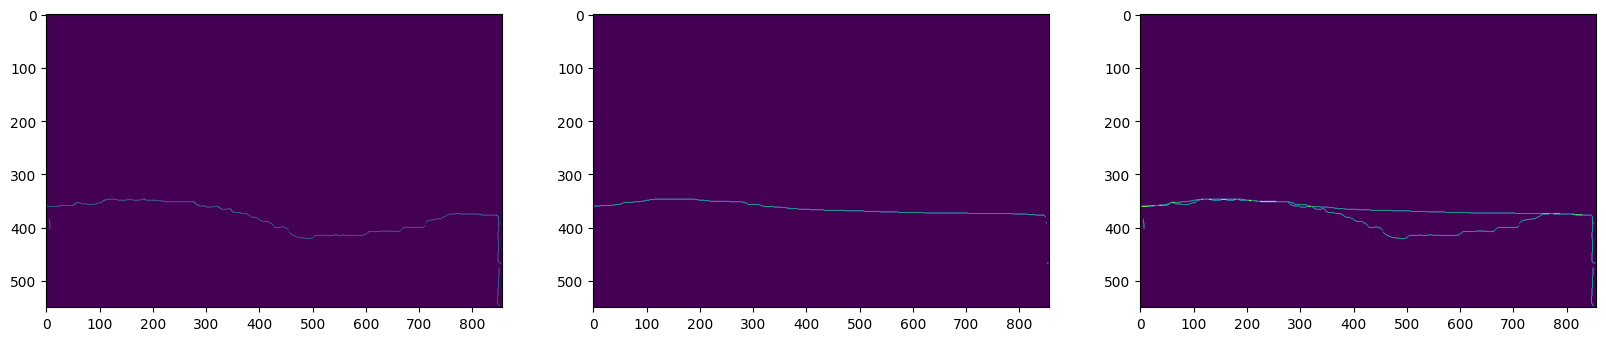

In [29]:
plt.figure(figsize=(20,20))

y = 10


plt.subplot(131)
plt.imshow(sum_line_r[y])

plt.subplot(132)
plt.imshow(hull_line_r[y])

plt.subplot(133)
plt.imshow(total_line_r[y])


In [30]:
gaussian_line_r = common_functions.get_3D_gaussian(total_line_r)
epithelial_r = gaussian_line_r*image_r

# Clean the bright line

In [31]:
def bresenham_line_3d(x1, y1, z1, x2, y2, z2):
    ListOfPoints = []
    ListOfPoints.append((x1, y1, z1))
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    dz = abs(z2 - z1)
    if (x2 > x1):
        xs = 1
    else:
        xs = -1
    if (y2 > y1):
        ys = 1
    else:
        ys = -1
    if (z2 > z1):
        zs = 1
    else:
        zs = -1

    # Driving axis is X-axis"
    if (dx >= dy and dx >= dz):        
        p1 = 2 * dy - dx
        p2 = 2 * dz - dx
        while (x1 != x2):
            x1 += xs
            if (p1 >= 0):
                y1 += ys
                p1 -= 2 * dx
            if (p2 >= 0):
                z1 += zs
                p2 -= 2 * dx
            p1 += 2 * dy
            p2 += 2 * dz
            ListOfPoints.append((x1, y1, z1))

    # Driving axis is Y-axis"
    elif (dy >= dx and dy >= dz):       
        p1 = 2 * dx - dy
        p2 = 2 * dz - dy
        while (y1 != y2):
            y1 += ys
            if (p1 >= 0):
                x1 += xs
                p1 -= 2 * dy
            if (p2 >= 0):
                z1 += zs
                p2 -= 2 * dy
            p1 += 2 * dx
            p2 += 2 * dz
            ListOfPoints.append((x1, y1, z1))

    # Driving axis is Z-axis"
    else:        
        p1 = 2 * dy - dz
        p2 = 2 * dx - dz
        while (z1 != z2):
            z1 += zs
            if (p1 >= 0):
                y1 += ys
                p1 -= 2 * dz
            if (p2 >= 0):
                x1 += xs
                p2 -= 2 * dz
            p1 += 2 * dy
            p2 += 2 * dx
            ListOfPoints.append((x1, y1, z1))
            
    return ListOfPoints

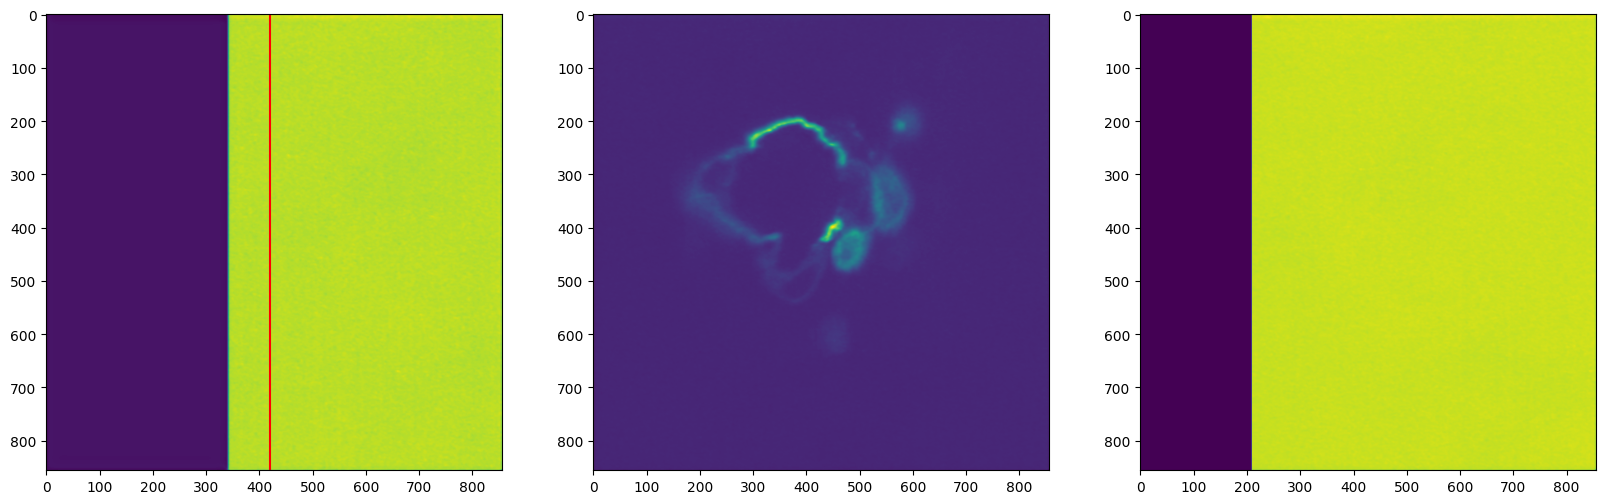

In [32]:
#### WE SHOULD DO IT AUTOMATICALLY OPENING THE IMAGE AND FINDING THE 0'S PLACING THE VALUE FOUND IN THOSE PIXELS AT THE LIMIT +- 5 

z = 0 ## Starting position of the dome
z1 = 280 ## place where you donpt see the line anymore

x = 420 ## Initial x where the line is
x1 = 0 ## last x where the line is found


def cut_image(image, z, z1, x, x1):

    line = bresenham_line_3d(z, 0, x, z1, 0, x1)
    image_cut = copy(image)

    for i in line:
        image_cut[i[0], :, :i[2]] = 0
    
    return image_cut

image_cut = cut_image(image, z, z1, x, x1)


plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(image[z])
plt.axvline(x, c='r')
plt.subplot(132)
plt.imshow(image[z1])
plt.axvline(x1, c='r')
plt.subplot(133)
plt.imshow(image_cut[int(z1/2)])


In [33]:
image_r = common_functions.get_image_r(image_cut)
epithelial_r = gaussian_line_r*image_r

# Replace all the < 108 pixels from the cut by random between 108 or 109 so the cut goes unnotice

In [34]:
# Step 1: Create a mask where the values are less than 108
mask = image_r < 30

# Step 2: Generate a random array of 108 or 109 with the same shape as the masked array
random_replacements = np.random.choice([30, 30.1], size=image_r.shape)

# Step 3: Replace the values in image_r using the mask
image_r[mask] = random_replacements[mask]

In [35]:
def gamma_correction(image, gamma):

    current_max = image.max()

    image = common_functions.normalize_image(image,1)

    image = image**gamma

    image = common_functions.normalize_image(image, current_max)

    return image


def mid_gamma_correction(image, mid=0.8):
    mean = np.mean(image)
    meanLog = math.log(mean)
    midLog = math.log(mid*255)
    gamma =midLog/meanLog
    gamma = 1 / gamma
    # print(gamma)

    return gamma_correction(image, gamma)


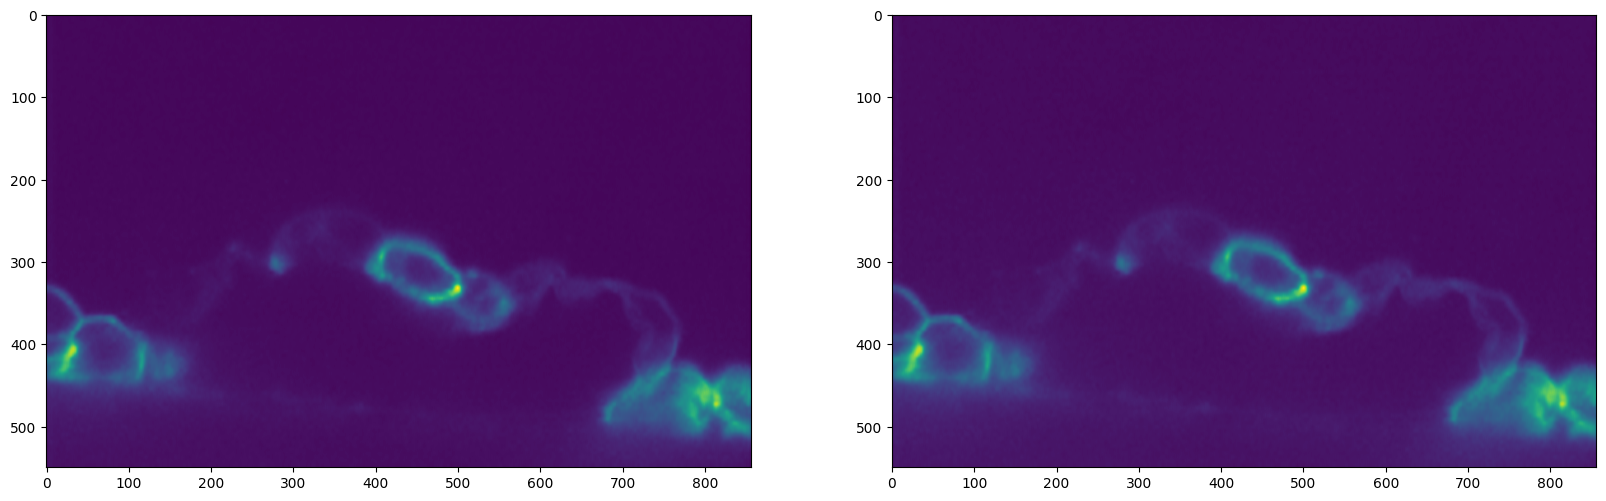

In [36]:
image_test = image_r[500]

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(image_test)



plt.subplot(122)
plt.imshow(mid_gamma_correction(image_test))

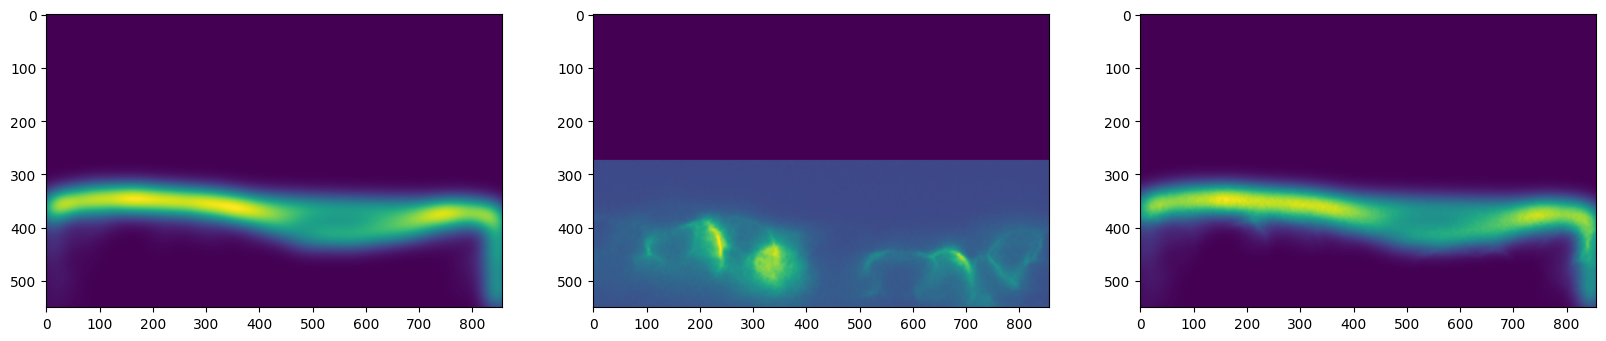

In [37]:
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(gaussian_line_r[y])
plt.subplot(132)
plt.imshow(image_r[y])
plt.subplot(133)
plt.imshow(common_functions.normalize_image(epithelial_r[10]))

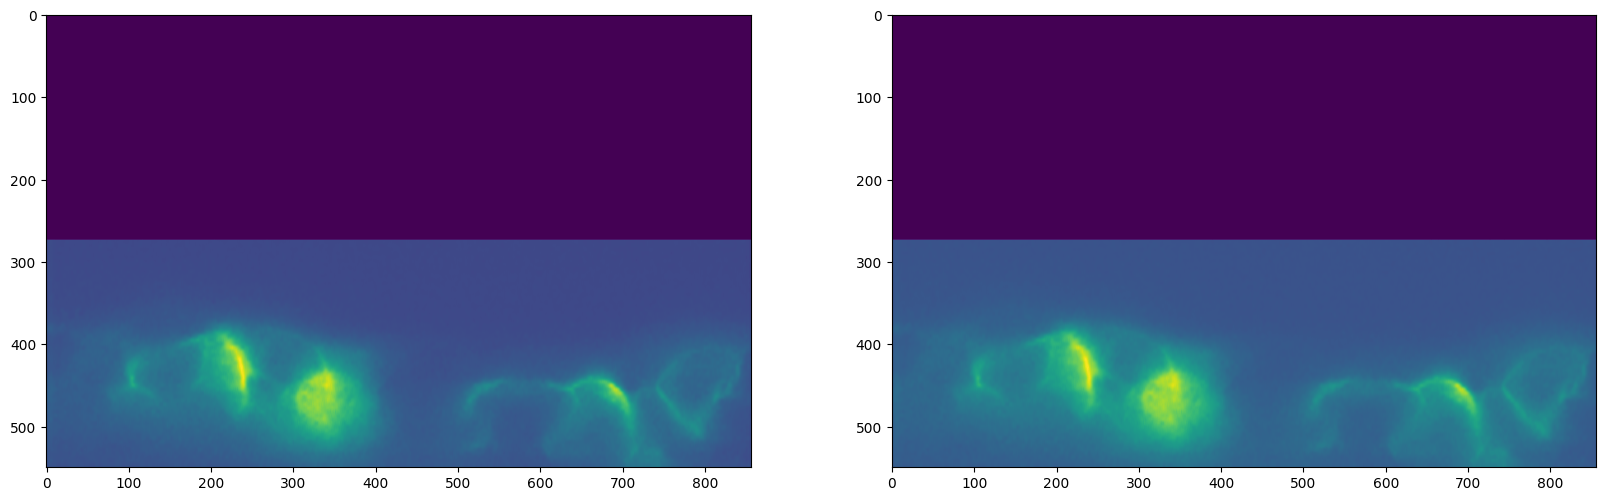

In [38]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(image_r[y])
plt.subplot(122)
plt.imshow(gamma_correction(image_r[y], 0.9))


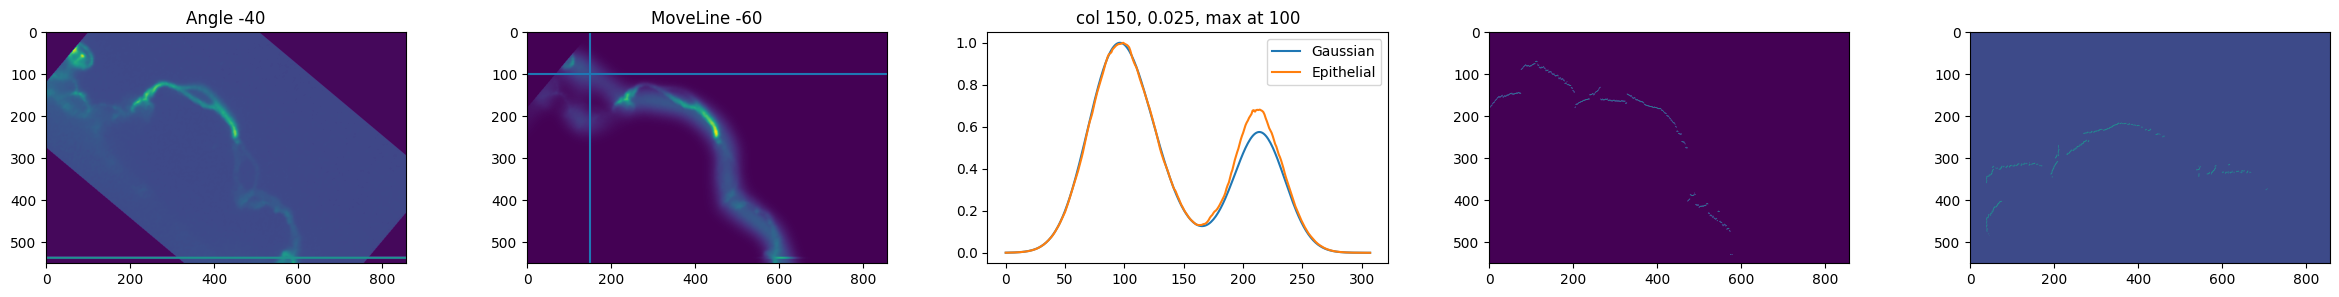

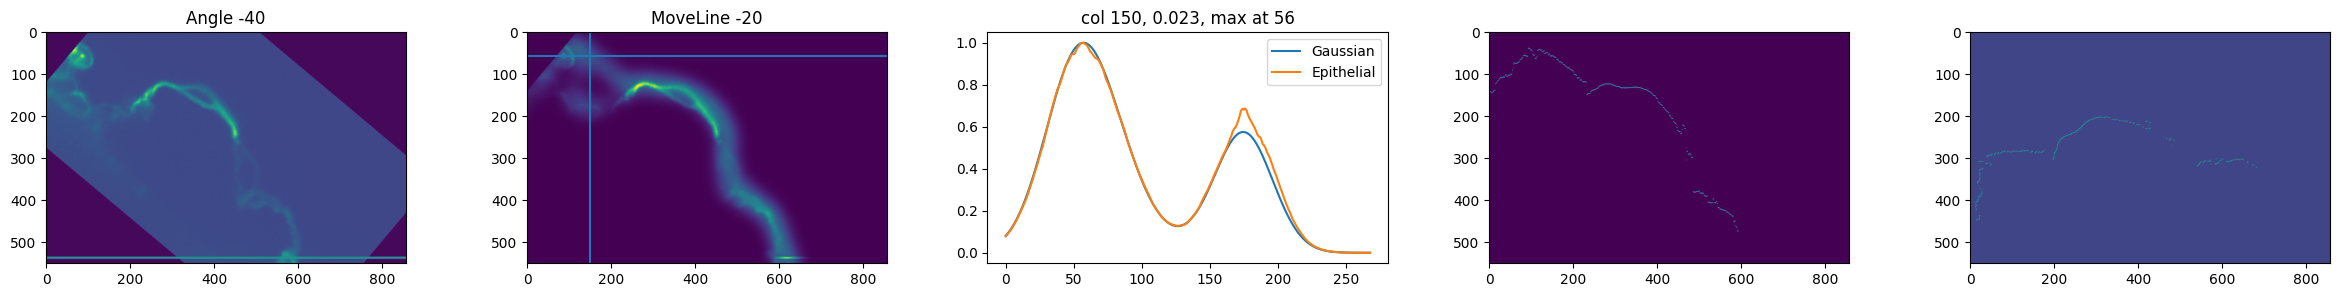

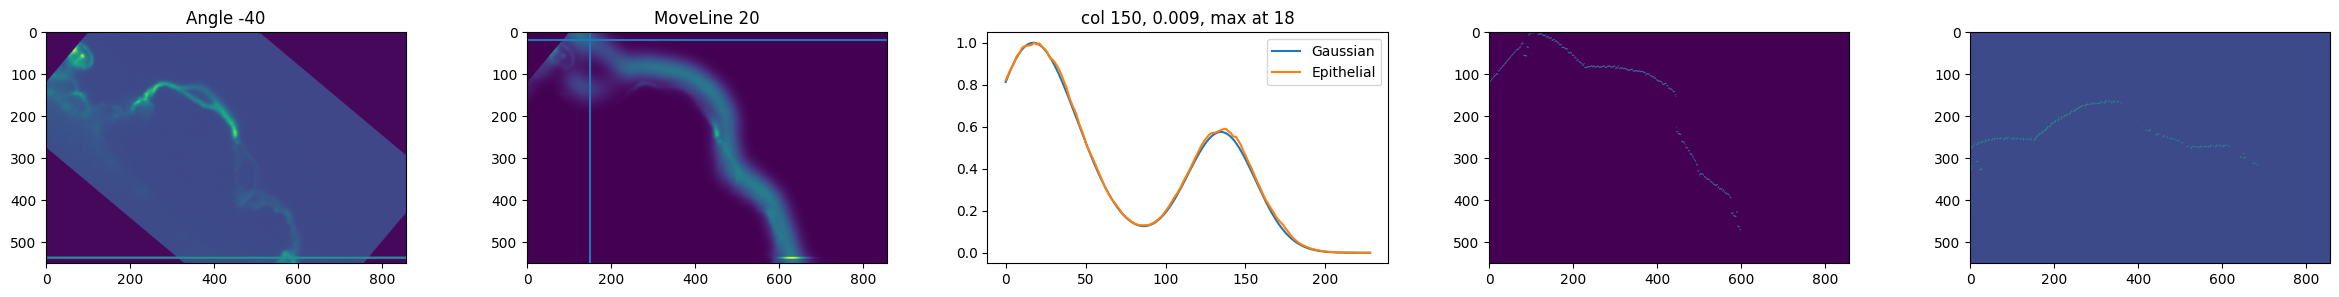

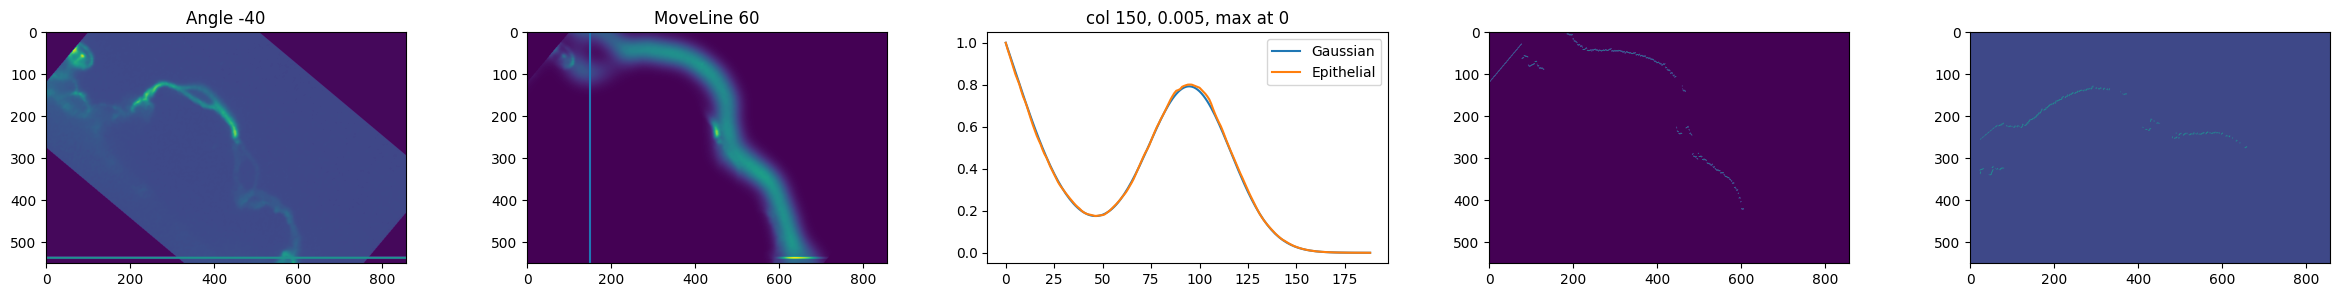

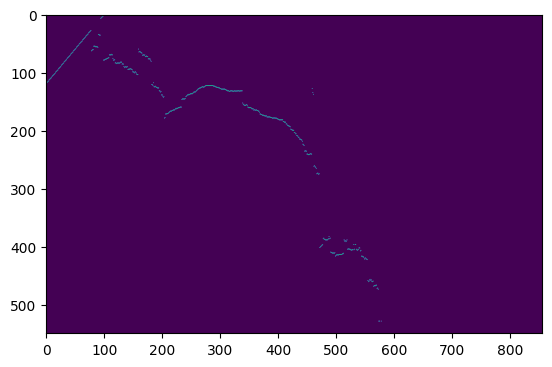

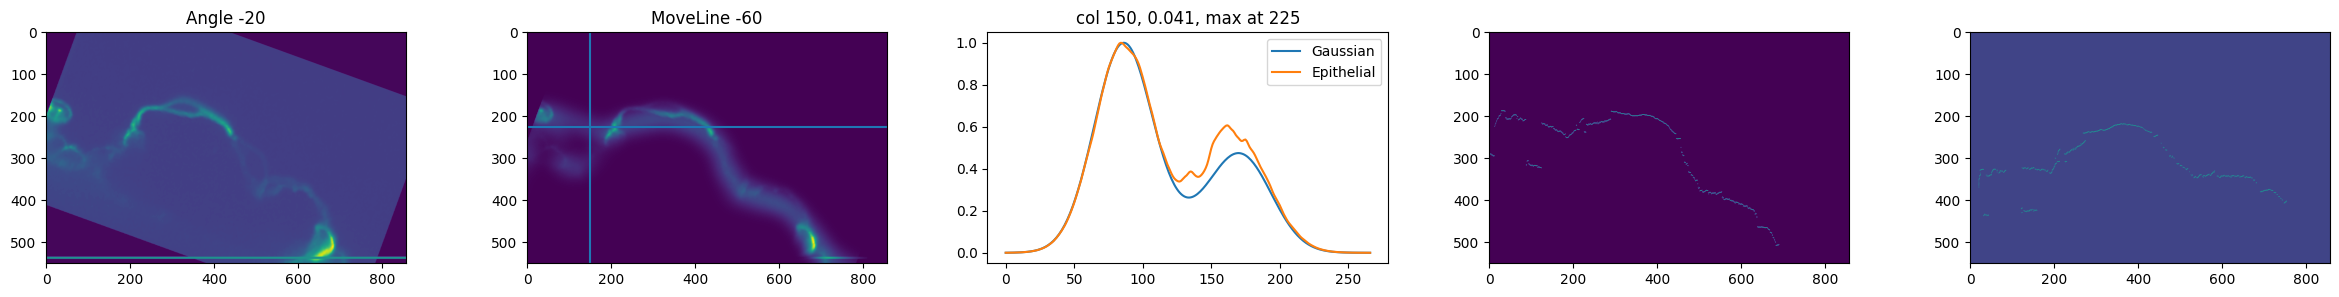

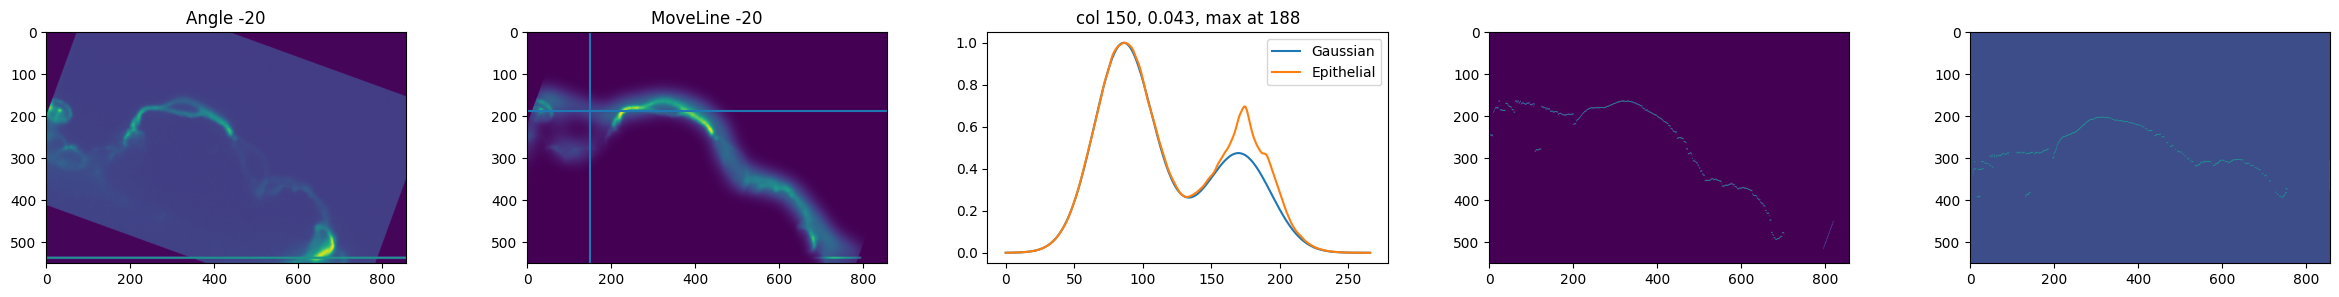

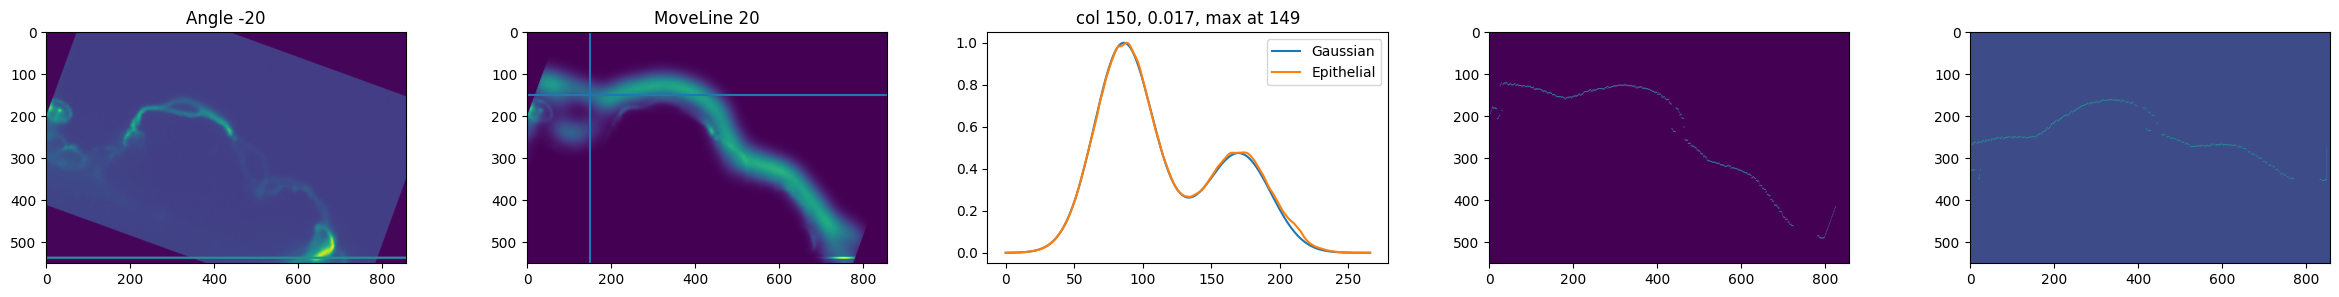

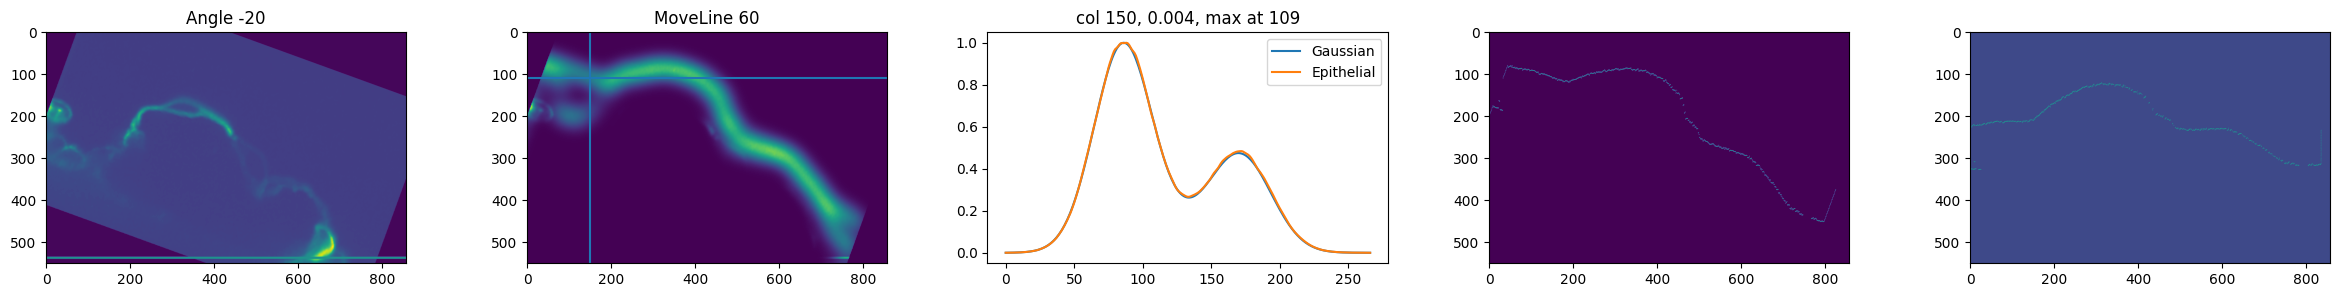

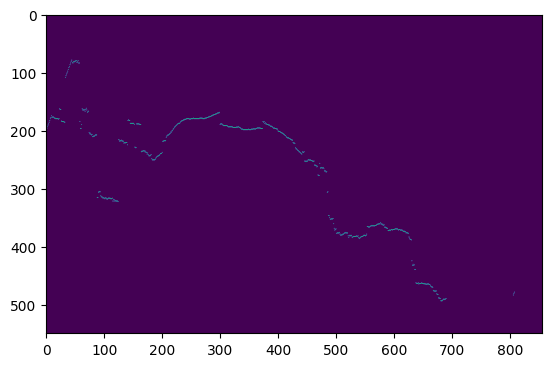

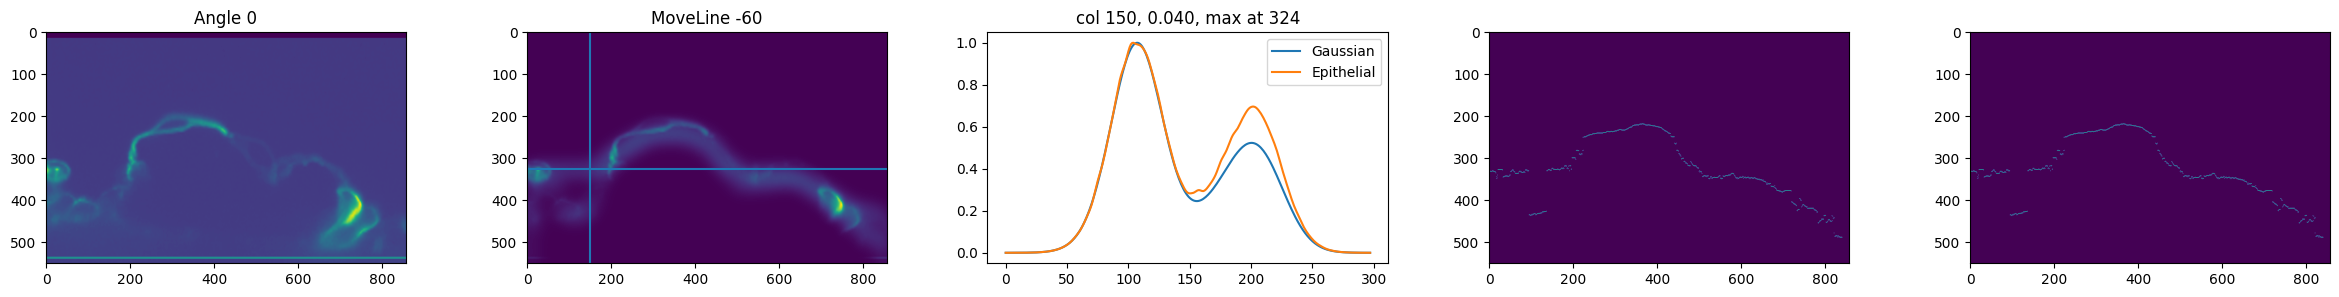

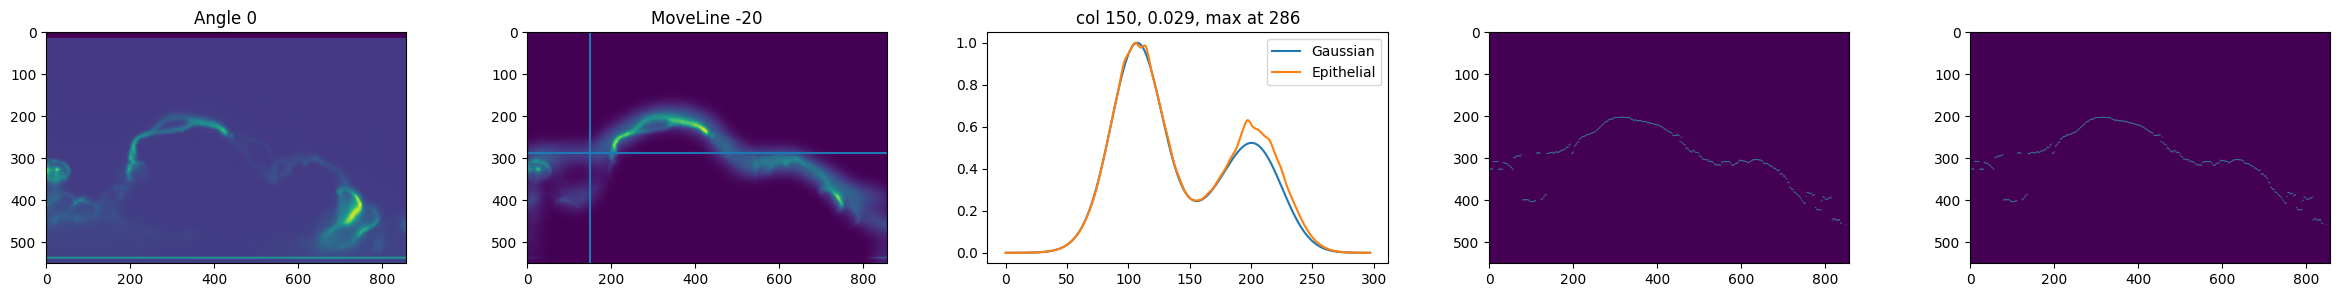

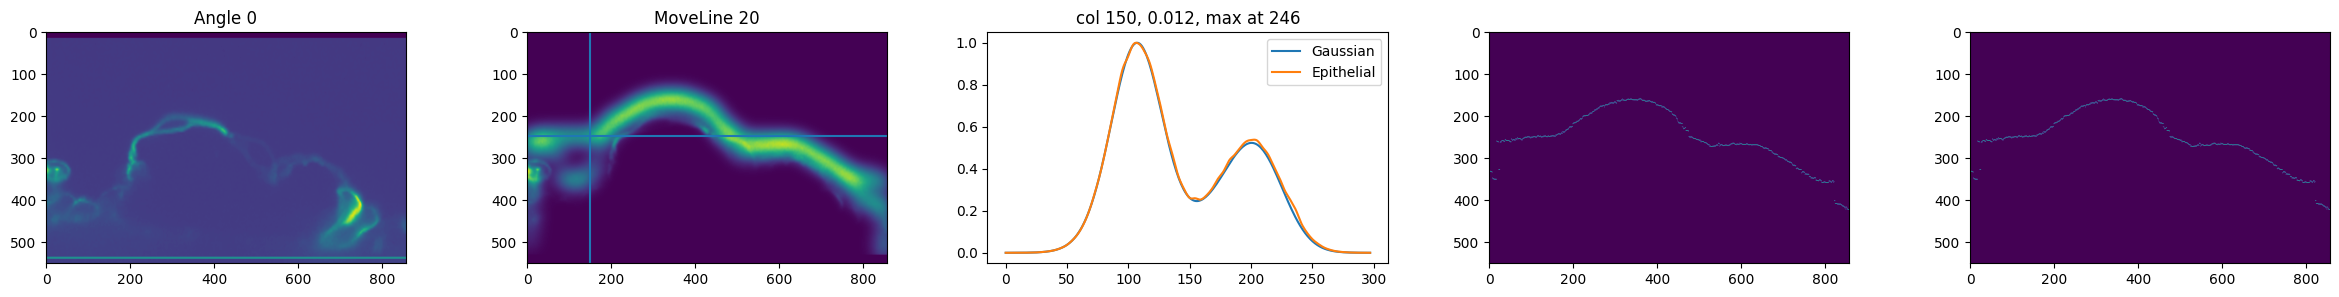

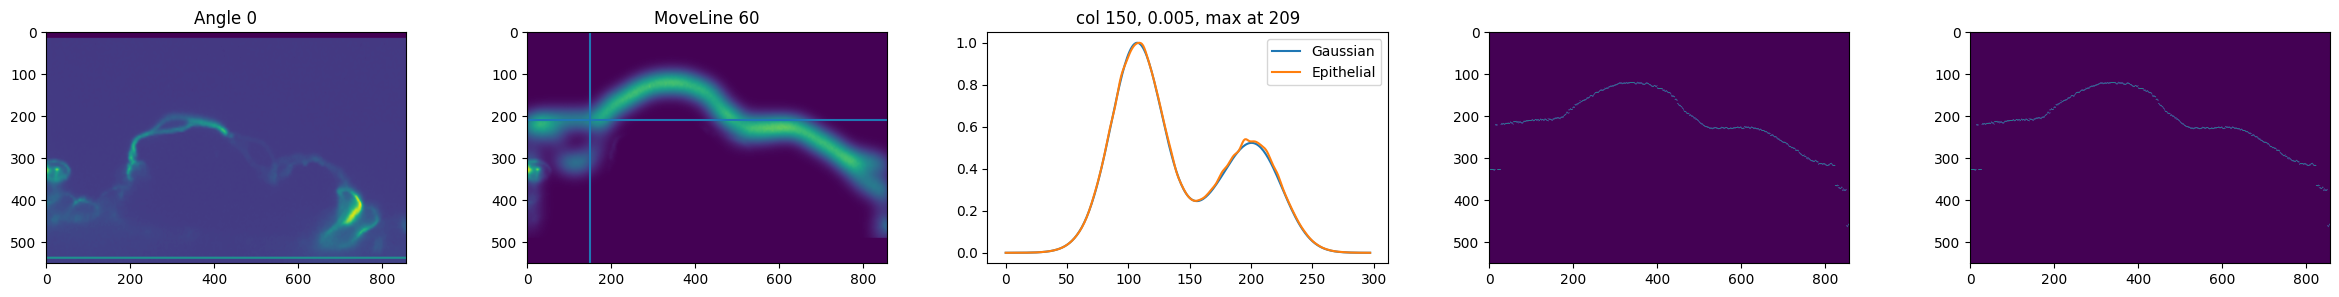

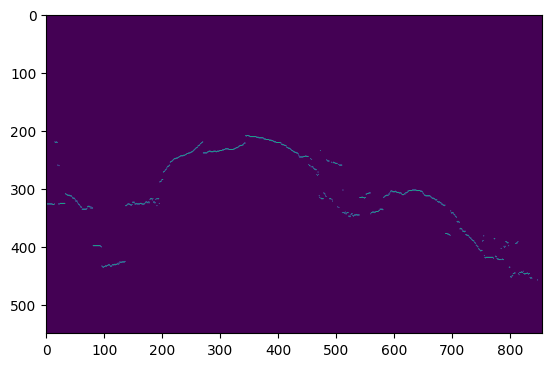

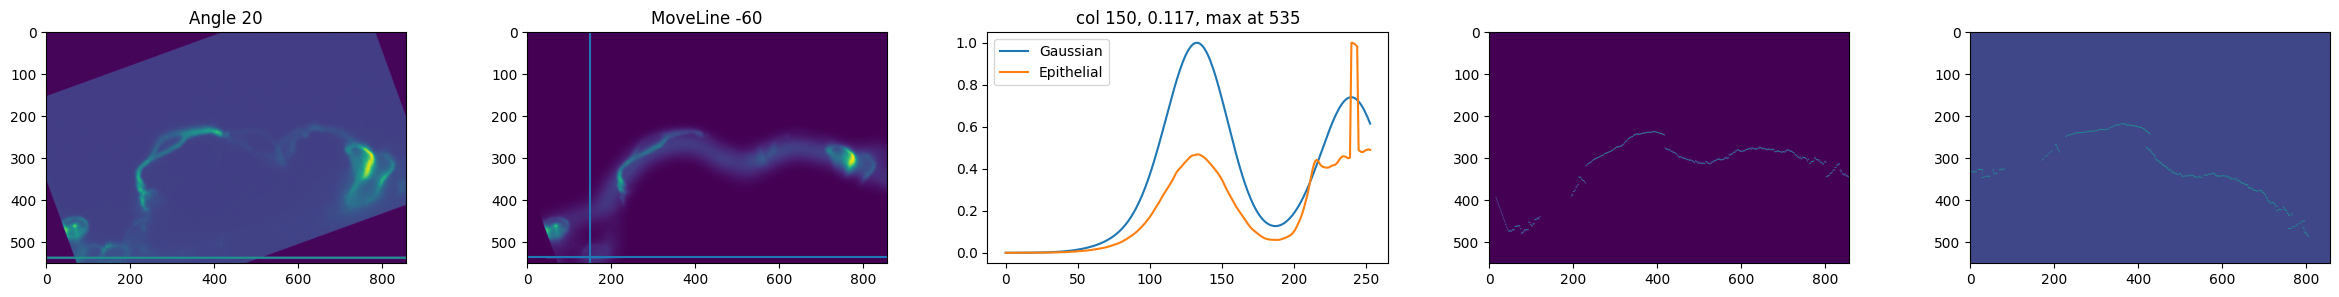

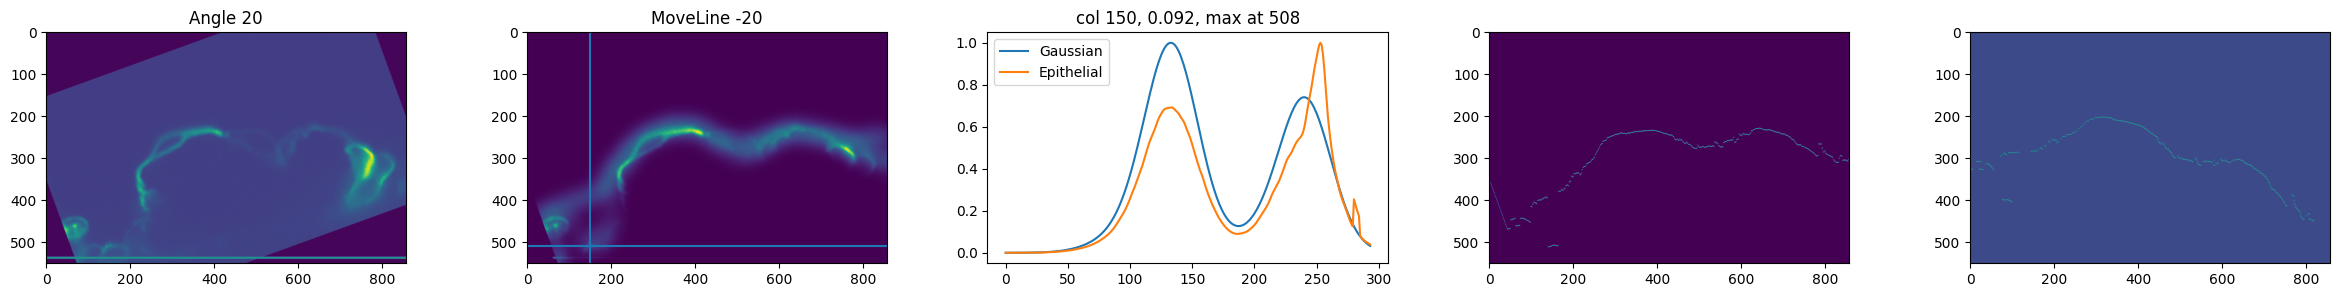

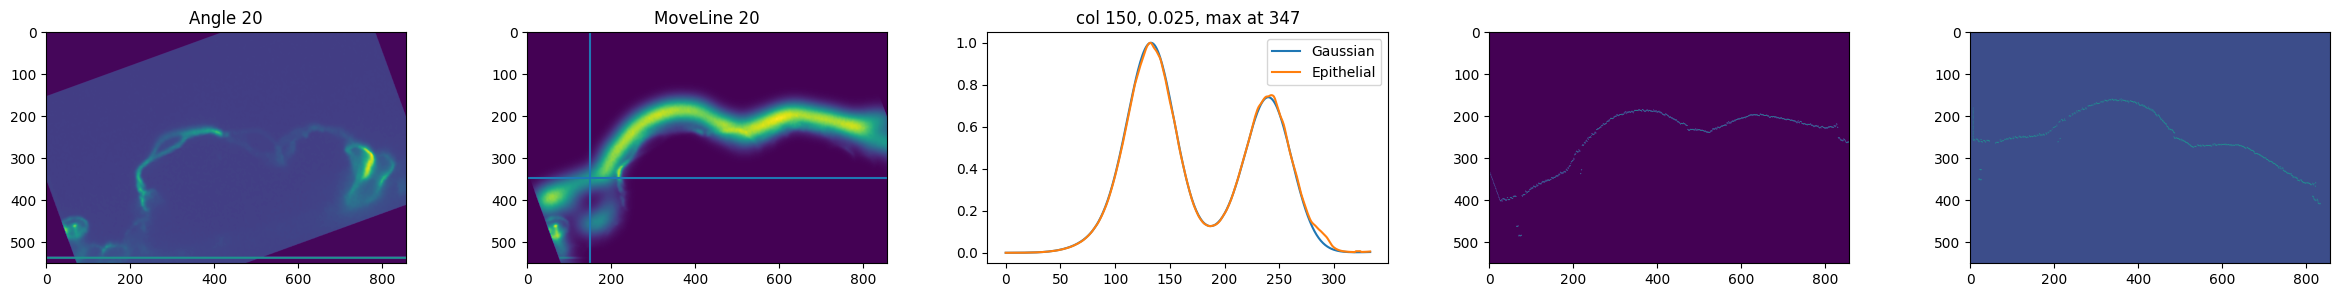

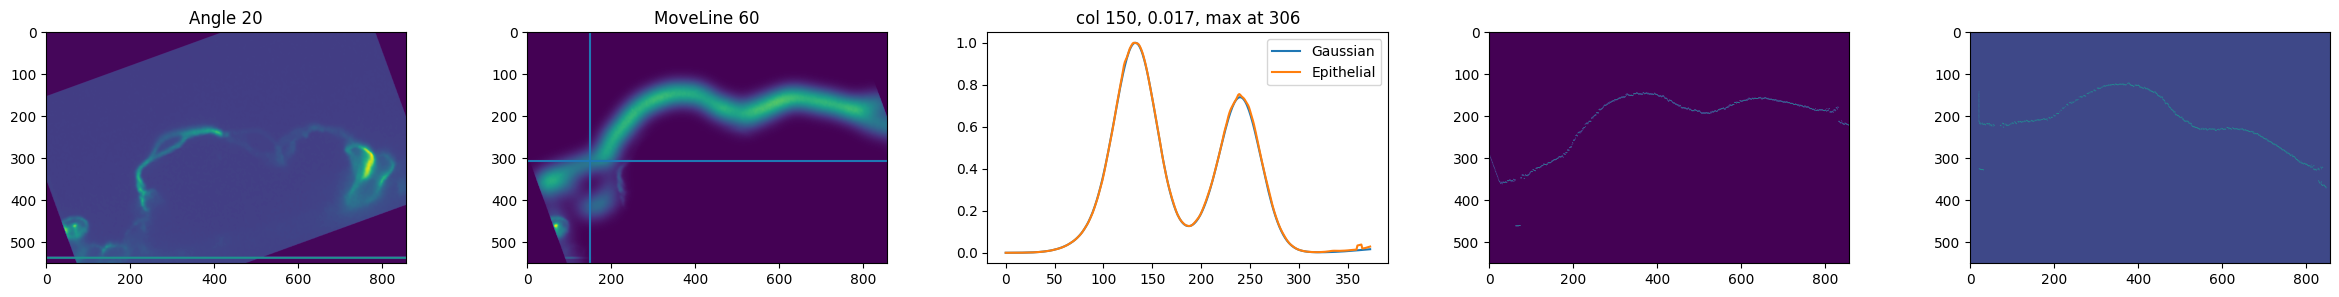

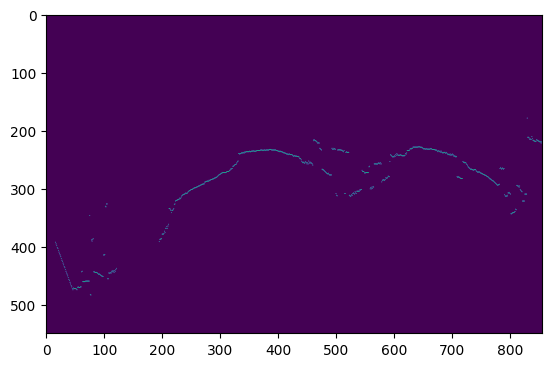

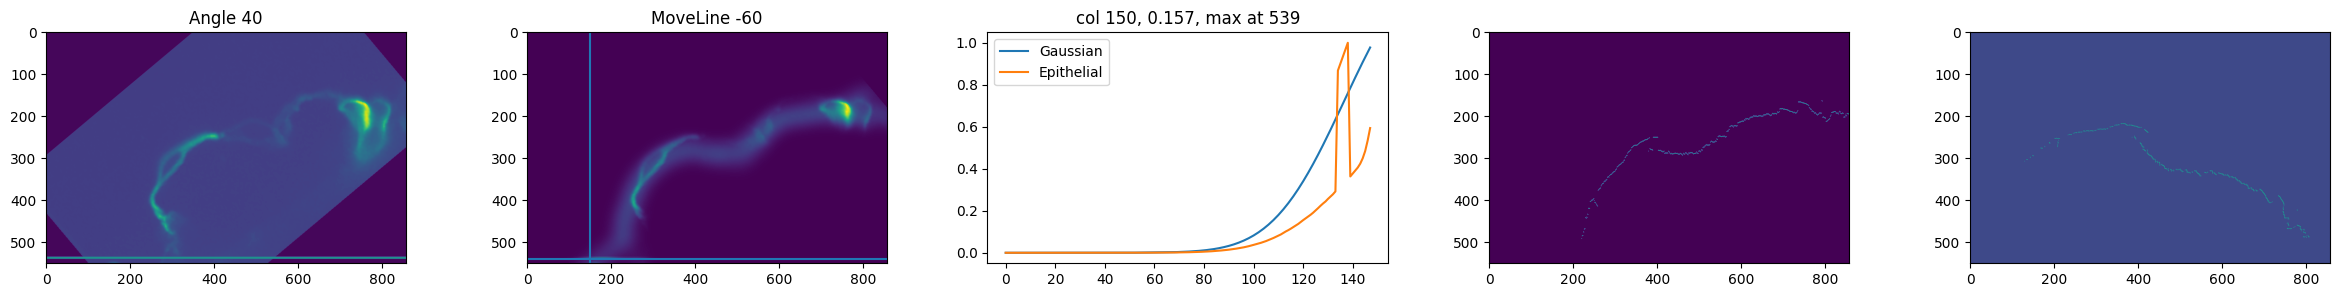

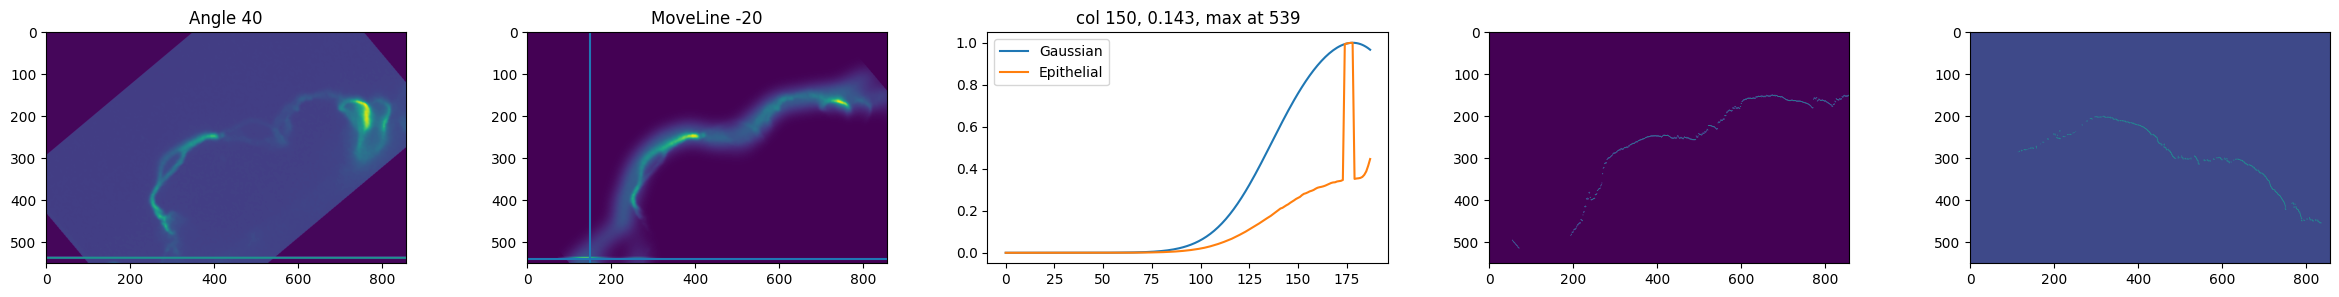

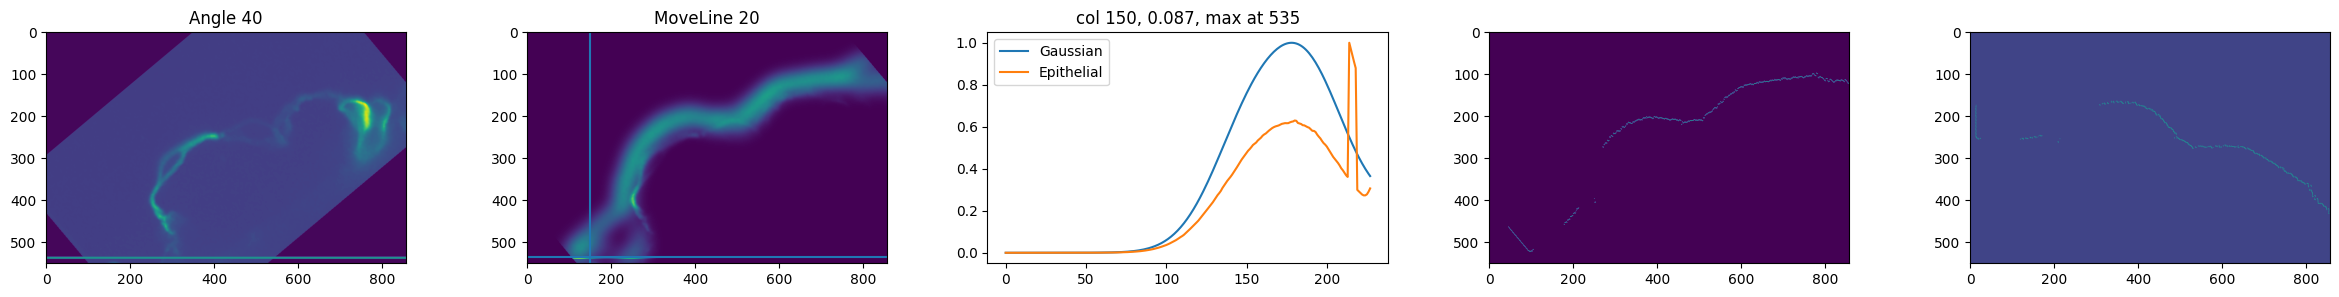

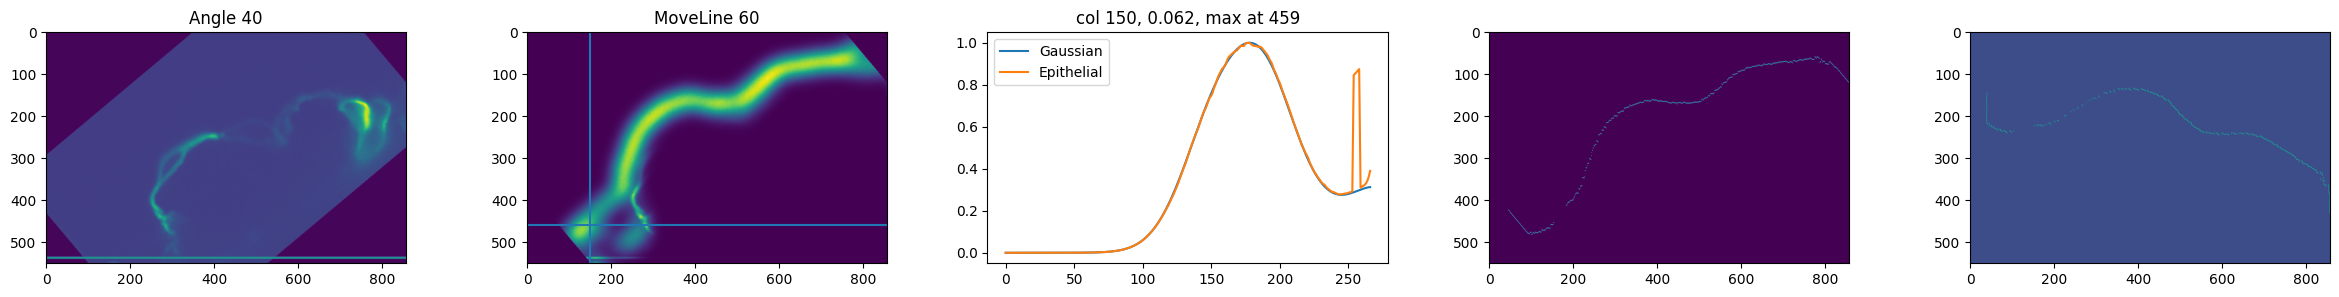

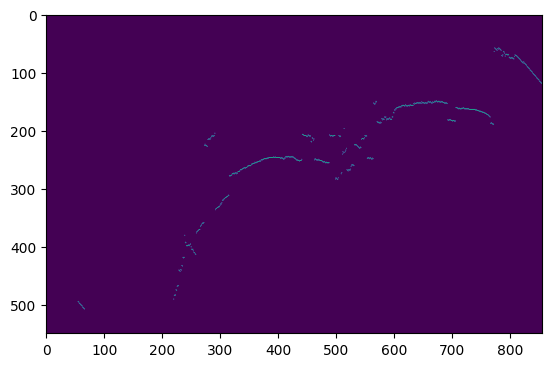

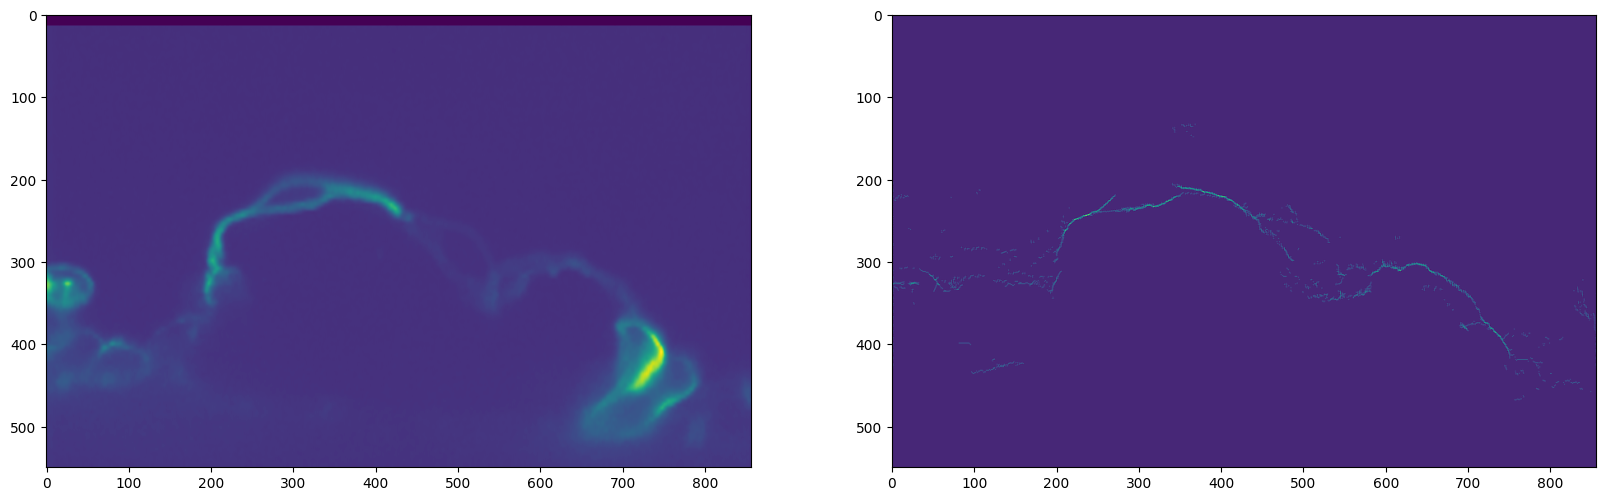

: 

In [44]:
def find_maximus(epithelial, moveLine, margin=5):

    max_intensity_indices =  np.argmax(epithelial, axis=0)

    apical = np.zeros(epithelial.shape)
    apical[max_intensity_indices, np.array(list(range(epithelial.shape[1])))] = 1

    # print(-moveLine-margin)

    if moveLine-margin > 0:
        apical[-moveLine-margin:, :] = 0

    return apical

# def super_apical_backup(image, gaussian, total_line, angle = 40, moveLine = 20, plots=False):

    total_apical = np.zeros((image.shape))

    angles = [i for i in range(-angle, angle+1, 20)]

    moveLines = [i for i in range(-moveLine, moveLine+1, 20)]

    p_values_array = np.zeros((len(angles)*len(moveLines), image.shape[1]))

    image = gamma_correction(image, 0.5)

    c = 0

    for angle in angles:
        rot_image = rotate(image, angle, reshape=False)
        rot_gaussian = rotate(gaussian, angle, reshape=True)
        rot_total_line = rotate(total_line, angle, reshape=True)

        for moveLine in moveLines:

            rot_gaussian_up = common_functions.move2D_array(rot_gaussian, moveLine)
            rot_total_line_up = common_functions.move2D_array(rot_total_line, moveLine)

            y_0 = np.array(rot_gaussian.shape[0])/2-np.array(image.shape[0])/2
            y_1 = np.array(rot_gaussian.shape[0])/2+np.array(image.shape[0])/2
            x_0 = np.array(rot_gaussian.shape[1])/2-np.array(image.shape[1])/2
            x_1 = np.array(rot_gaussian.shape[1])/2+np.array(image.shape[1])/2

            y_0, y_1, x_0, x_1 = int(y_0), int(y_1), int(x_0), int(x_1)

            rot_gaussian_up = rot_gaussian_up[y_0:y_1, x_0:x_1]
            rot_total_line_up = rot_total_line_up[y_0:y_1, x_0:x_1]
            rot_total_line_up = common_functions.normalize_image(rot_total_line_up, 255)


            rot_epithelial = rot_image*rot_gaussian_up

            margin = 0
            apical = find_maximus(rot_epithelial, moveLine, margin)

            ## Check distance to origin of gaussian and also compare the intensity at a given point with its neighbour to check it is not background?
            for x in range(rot_epithelial.shape[1]):
                column = apical[:, x]
                lines = rot_total_line_up[:, x]
                lines[lines >= 1] = 1
                if sum(column) == 0:
                    pass
                else:
                    position_of_dot = np.where(column == 1)[0][0]
                    
                    position_of_lines = np.where(lines >= 1)[0]

                    # if len(position_of_lines):
                    #     position_of_lines = position_of_lines.mean()
                    
                    if not len(position_of_lines):
                        position_of_lines = np.array([0])




                    # Center point coordinates
                    center_y, center_x = position_of_dot, x

                    # Define the size of the neighborhood (e.g., 3x3)
                    neighborhood_size = 40
                    half_size = neighborhood_size // 2

                    # Extract the neighborhood
                    neighborhood = rot_image[
                        max(center_y - half_size, 0) : min(center_y + half_size + 1, rot_image.shape[0]),
                        max(center_x - half_size, 0) : min(center_x + half_size + 1, rot_image.shape[1])
                    ]

                    # mean_value = np.mean(neighborhood)

                    evaluate = 400

                    # print(f'value on image {rot_image[center_y, center_x]}, mean_value {mean_value}, position of dot {position_of_dot}, lines {position_of_lines}') if x == evaluate else None
                    
                    # print(abs(position_of_lines-position_of_dot)) if x == 550 else None

                    # filter_margin_of_intensity = abs(1-rot_image[center_y, center_x] / mean_value) < 0.05

                    # print(f'Filter intensity {filter_margin_of_intensity}, {abs(1-rot_image[center_y, center_x] / mean_value)}') if x == evaluate else None

                    # filter_margin_of_distance = abs(position_of_lines-position_of_dot) <= 0.05*len(column) ## Done with the mean of position_of_lines (not removing the close points to one line)

                    # filter_margin_of_distance = abs(position_of_lines-position_of_dot).min()/len(column) < 0.5 # Try to get the smallest distance

                    # print(f'Filter distance {filter_margin_of_distance}, {abs(position_of_lines-position_of_dot).min()}') if x == evaluate else None

                    gaussian_distribution = common_functions.normalize_image(rot_gaussian_up[:, x])
                    # rot_epithelial = common_functions.gaussian_2D(rot_epithelial, 0.3)
                    epithelial_distribution = common_functions.normalize_image(rot_epithelial[:, x])

                    ks_stat, p_value = ks_2samp(epithelial_distribution, gaussian_distribution)
                    print(ks_stat, p_value) if x == evaluate else None

                    p_values_array[c, x] = p_value


                    # filter_distribution = p_value > 0.95

                    # print(f'Filter distribution {filter_distribution}, p_value {p_value}') if x == evaluate else None



                    

                    
                    # if filter_distribution:
                    #     # print('no')
                    #     apical[center_y, center_x] = 0

                    # print(image[center_y, center_x], mean_value, center_y, center_x)

            
            if plots:
                cols=5
                rows=1
                plt.figure(figsize=(30, 3))
                plt.subplot(rows, cols, 1)
                plt.title(f'Angle {angle}')
                plt.imshow(rot_image)
                plt.subplot(rows, cols, 2)
                plt.title(f'MoveLine {moveLine}')
                plt.imshow(rot_epithelial)
                plt.subplot(rows, cols, 3)
                plt.title(f'Evaluation at {evaluate}, {p_value:.4f}, {ks_stat:.2f}')
                plt.plot(gaussian_distribution, label='Gaussian')
                plt.plot(epithelial_distribution, label='Epithelial')
                plt.legend()
                plt.subplot(rows, cols, 4)
                plt.imshow(rot_total_line_up)
                plt.subplot(rows, cols, 5)
                plt.imshow(apical)
                if moveLine-margin >= 1:
                    plt.axhline(apical.shape[0]-moveLine-margin)

            c+=1


            # apical = apical * rot_gaussian_up
            apical = rotate(apical, -angle, reshape=False)

            total_apical += apical





    return total_apical, p_values_array



# def super_apical(image, gaussian, angles, moveLines, plots=False):

    warnings.filterwarnings("ignore", category=RuntimeWarning) 

    total_apical = np.zeros((image.shape))

    # image = gamma_correction(image, 2)

    c = 0

    apical_i = np.zeros((len(angles)*len(moveLines), image.shape[0], image.shape[1]))
    

    for angle in angles:
        rot_image = rotate(image, angle, reshape=False)
        rot_gaussian = rotate(gaussian, angle, reshape=True)

        p_values_ml = np.zeros((len(moveLines), rot_image.shape[1]))

        m = 0

        for moveLine in moveLines:

            rot_gaussian_up = common_functions.move2D_array(rot_gaussian, moveLine)


            y_0 = np.array(rot_gaussian.shape[0])/2-np.array(image.shape[0])/2
            y_1 = np.array(rot_gaussian.shape[0])/2+np.array(image.shape[0])/2
            x_0 = np.array(rot_gaussian.shape[1])/2-np.array(image.shape[1])/2
            x_1 = np.array(rot_gaussian.shape[1])/2+np.array(image.shape[1])/2

            y_0, y_1, x_0, x_1 = int(y_0), int(y_1), int(x_0), int(x_1)

            rot_gaussian_up = rot_gaussian_up[y_0:y_1, x_0:x_1]

            rot_epithelial = rot_image*rot_gaussian_up

            margin = 0
            apical_rot_ml = find_maximus(rot_epithelial, moveLine, margin)
            apical_i[c] = apical_rot_ml
            c+=1

            for x in range(rot_epithelial.shape[1]):
                column = apical_rot_ml[:, x]

                if sum(column) == 0:
                    pass
                else:
                    position_of_dot = np.where(column == 1)[0][0]

                    evaluate = '500'

                    gaussian_distribution = common_functions.normalize_image(rot_gaussian_up[:, x])
                    # rot_epithelial = common_functions.gaussian_2D(rot_epithelial, 0.3)
                    epithelial_distribution = common_functions.normalize_image(rot_epithelial[:, x])

                    ks_stat, p_value = ks_2samp(epithelial_distribution, gaussian_distribution)
                    print(f'{evaluate}, angle {angle}, move line {moveLine}, {ks_stat:.2f}, p value {p_value:.2f}') if x == evaluate else None

                    p_values_ml[m,x] = p_value


            

            m+=1


                    
            
            if plots:
                evaluate = int(evaluate)
                cols=5
                rows=1
                plt.figure(figsize=(30, 3))
                plt.subplot(rows, cols, 1)
                plt.title(f'Angle {angle}')
                plt.imshow(rot_image)
                plt.subplot(rows, cols, 2)
                plt.title(f'MoveLine {moveLine}')
                plt.imshow(rot_epithelial)
                plt.subplot(rows, cols, 3)
                ks_stat, p_value = ks_2samp(common_functions.normalize_image(rot_epithelial[:, evaluate]), common_functions.normalize_image(rot_gaussian_up[:, evaluate]))
                plt.title(f'col {evaluate}, {ks_stat:.3f}, {p_value:.3f}')
                plt.plot(common_functions.normalize_image(rot_gaussian_up[:, evaluate]), label='Gaussian')
                plt.plot(common_functions.normalize_image(rot_epithelial[:, evaluate]), label='Epithelial')
                plt.legend()
                plt.subplot(rows, cols, 4)
                plt.imshow(rot_gaussian_up)
                plt.subplot(rows, cols, 5)
                plt.imshow(rotate(apical_rot_ml, -angle, reshape=False))
                if moveLine-margin >= 1:
                    plt.axhline(apical_rot_ml.shape[0]-moveLine-margin)


            

        p_values_ml[p_values_ml < p_values_ml.mean(axis=0, keepdims=True)] = True
        p_values_ml[p_values_ml != True] = False

        # print(p_values_ml.shape)
        mask_expanded = np.repeat(p_values_ml[:, np.newaxis, :], apical_i.shape[1], axis=1)
        # print(mask_expanded.shape)
        # print(apical_i.shape)

    
        apical_i[mask_expanded == False] = 0

        apical_i = np.sum(apical_i, axis=0)
                
            # apical = apical_rot_ml

            # c+=1
            # m+=1




        apical = rotate(apical_i, -angle, reshape=False)

        total_apical += apical





    return total_apical




# def super_apical(image, gaussian, angles, moveLines, plots=False):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    total_apical = np.zeros(image.shape)
    apical_i = np.zeros((len(angles) * len(moveLines), image.shape[0], image.shape[1]))
    c = 0

    for angle in angles:
        # Rotate image and Gaussian
        rot_image = rotate(image, angle, reshape=False)
        rot_gaussian = rotate(gaussian, angle, reshape=True)
        
        p_values_ml = np.zeros((len(moveLines), rot_image.shape[1]))

        for m, moveLine in enumerate(moveLines):
            # Move Gaussian and crop to match the image shape
            rot_gaussian_up = common_functions.move2D_array(rot_gaussian, moveLine)
            y_0 = (rot_gaussian.shape[0] - image.shape[0]) // 2
            y_1 = y_0 + image.shape[0]
            x_0 = (rot_gaussian.shape[1] - image.shape[1]) // 2
            x_1 = x_0 + image.shape[1]
            rot_gaussian_up = rot_gaussian_up[y_0:y_1, x_0:x_1]

            # Calculate rotated epithelial
            rot_epithelial = rot_image * rot_gaussian_up
            apical_rot_ml = find_maximus(rot_epithelial, moveLine, 0)
            apical_i[c] = apical_rot_ml
            c += 1

            for x in range(rot_epithelial.shape[1]):
                column = apical_rot_ml[:, x]
                if np.sum(column) > 0:
                    position_of_dot = np.where(column == 1)[0][0]
                    gaussian_distribution = common_functions.normalize_image(rot_gaussian_up[:, x])
                    epithelial_distribution = common_functions.normalize_image(rot_epithelial[:, x])
                    _, p_value = ks_2samp(epithelial_distribution, gaussian_distribution)
                    p_values_ml[m, x] = p_value

            if plots:
                plot_results(angle, moveLine, evaluate, rot_image, rot_epithelial, rot_gaussian_up, apical_rot_ml)

        # Apply mask to p_values_ml
        mean_p_values = p_values_ml.mean(axis=0, keepdims=True)
        p_values_ml = np.where(p_values_ml < mean_p_values, True, False)
        
        # Expand mask and apply to apical_i
        mask_expanded = np.repeat(p_values_ml[:, np.newaxis, :], apical_i.shape[1], axis=1)
        apical_i[mask_expanded == False] = 0

        # Sum across all layers
        summed_apical_i = np.sum(apical_i, axis=0)
        
        # Rotate back and add to total_apical
        total_apical += rotate(summed_apical_i, -angle, reshape=False)

    return total_apical

# def plot_results(angle, moveLine, evaluate, rot_image, rot_epithelial, rot_gaussian_up, apical_rot_ml):
    evaluate = int(evaluate)
    cols = 5
    rows = 1
    plt.figure(figsize=(30, 3))
    plt.subplot(rows, cols, 1)
    plt.title(f'Angle {angle}')
    plt.imshow(rot_image)
    plt.subplot(rows, cols, 2)
    plt.title(f'MoveLine {moveLine}')
    plt.imshow(rot_epithelial)
    plt.subplot(rows, cols, 3)
    ks_stat, p_value = ks_2samp(common_functions.normalize_image(rot_epithelial[:, evaluate]),
                                common_functions.normalize_image(rot_gaussian_up[:, evaluate]))
    plt.title(f'col {evaluate}, {ks_stat:.3f}, {p_value:.3f}')
    plt.plot(common_functions.normalize_image(rot_gaussian_up[:, evaluate]), label='Gaussian')
    plt.plot(common_functions.normalize_image(rot_epithelial[:, evaluate]), label='Epithelial')
    plt.legend()
    plt.subplot(rows, cols, 4)
    plt.imshow(rot_gaussian_up)
    plt.subplot(rows, cols, 5)
    plt.imshow(rotate(apical_rot_ml, -angle, reshape=False))
    if moveLine - 0 >= 1:
        plt.axhline(apical_rot_ml.shape[0] - moveLine - 0)


def find_first_last_nonzero(arr):
    non_zero_indices = np.nonzero(arr)[0]
    if non_zero_indices.size == 0:
        return None, None
    first_nonzero = arr[non_zero_indices[0]]
    last_nonzero = arr[non_zero_indices[-1]]
    return first_nonzero, last_nonzero

def find_first_last_nonzero_indices(arr):
    non_zero_indices = np.nonzero(arr)[0]
    if non_zero_indices.size == 0:
        return None, None
    first_nonzero_index = non_zero_indices[0]
    last_nonzero_index = non_zero_indices[-1]
    return first_nonzero_index, last_nonzero_index

def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

def super_apical(image, gaussian, angles, moveLines, margin_cut = 5, plots=False):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    total_apical = np.zeros(image.shape)
    image = mid_gamma_correction(image)
    apical_i = np.zeros((len(moveLines), image.shape[0], image.shape[1]))

    for angle in angles:
        # Rotate image and Gaussian
        rot_image = rotate(image, angle, reshape=False)

        if margin_cut > 0:
            rot_image[rot_image.shape[0]-3*int(margin_cut/4):rot_image.shape[0]-2*int(margin_cut/4), :] = rot_image.max()/2

        rot_gaussian = rotate(gaussian, angle, reshape=True)
        
        p_values_ml = np.zeros((len(moveLines), rot_image.shape[1]))

        for m, moveLine in enumerate(moveLines):
            # Move Gaussian and crop to match the image shape
            rot_gaussian_up = common_functions.move2D_array(rot_gaussian, moveLine)
            y_0 = (rot_gaussian.shape[0] - image.shape[0]) // 2
            y_1 = y_0 + image.shape[0]
            x_0 = (rot_gaussian.shape[1] - image.shape[1]) // 2
            x_1 = x_0 + image.shape[1]
            rot_gaussian_up = rot_gaussian_up[y_0:y_1, x_0:x_1]

            # Calculate rotated epithelial
            rot_epithelial = rot_image * rot_gaussian_up
            apical_rot_ml = find_maximus(rot_epithelial, moveLine, margin=0)
            apical_i[m] = apical_rot_ml

            for x in range(rot_epithelial.shape[1]):
                column = apical_rot_ml[:, x]
                if np.sum(column) > 0:

                    gaussian_distribution = common_functions.normalize_image(rot_gaussian_up[:, x])
                    epithelial_distribution = common_functions.normalize_image(rot_epithelial[:, x])

                    first_nonzero_gaus, last_nonzero_gaus = find_first_last_nonzero_indices(gaussian_distribution)
                    rot_epithelial_norm_array = gaussian_distribution[first_nonzero_gaus:last_nonzero_gaus]
                    rot_gaussian_norm_array = epithelial_distribution[first_nonzero_gaus:last_nonzero_gaus]

                    distance = jensen_shannon_distance(rot_epithelial_norm_array, rot_gaussian_norm_array)

                    p_values_ml[m, x] = distance

            if plots:
                plot_results(angle, moveLine, rot_image, rot_epithelial, rot_gaussian_up, apical_rot_ml, margin_cut)

        #### test 1: filter by mean ####
        # mean_p_values = p_values_ml.mean(axis=0, keepdims=True)
        # p_values_ml = np.where(p_values_ml > mean_p_values, True, False)
        ####

        #### test 2: just keep the maximum value ####
        min_values_per_column = np.max(p_values_ml, axis=0)
        p_values_ml = np.where(p_values_ml == min_values_per_column, True, False)
        ####
        
        mask_expanded = np.repeat(p_values_ml[:, np.newaxis, :], apical_i.shape[1], axis=1)
        apical_i[mask_expanded == False] = 0

        # Sum across all layers
        summed_apical_i = np.sum(apical_i, axis=0)

        summed_apical_i[-margin_cut:] = 0

        if plots:
            plt.figure()
            plt.imshow(summed_apical_i) 
            plt.show()
        
        # Rotate back and add to total_apical
        apical = rotate(summed_apical_i, -angle, reshape=False)
        total_apical += apical


    return total_apical

def plot_results(angle, moveLine, rot_image, rot_epithelial, rot_gaussian_up, apical_rot_ml, margin_cut):
    cols = 5
    rows = 1
    evaluate = 150  # This can be adjusted based on your specific needs

    max_found = np.argmax(rot_epithelial[:, evaluate])

    plt.figure(figsize=(30, 3))
    plt.subplot(rows, cols, 1)
    plt.title(f'Angle {angle}')
    plt.imshow(rot_image)
    plt.subplot(rows, cols, 2)
    plt.title(f'MoveLine {moveLine}')
    plt.axvline(evaluate)
    plt.axhline(max_found)
    plt.imshow(rot_epithelial)
    plt.subplot(rows, cols, 3)

    

    rot_epithelial_norm_array = common_functions.normalize_image(rot_epithelial[:, evaluate], 1)
    rot_gaussian_norm_array = common_functions.normalize_image(rot_gaussian_up[:, evaluate], 1)

    # first_nonzero_ep, last_nonzero_ep = find_first_last_nonzero_indices(rot_epithelial_norm_array)
    first_nonzero_gaus, last_nonzero_gaus = find_first_last_nonzero_indices(rot_gaussian_norm_array)

    rot_epithelial_norm_array = rot_epithelial_norm_array[first_nonzero_gaus:last_nonzero_gaus]
    rot_gaussian_norm_array = rot_gaussian_norm_array[first_nonzero_gaus:last_nonzero_gaus]

    # ks_stat, p_value = ks_2samp(rot_epithelial_norm_array,
    #                             rot_gaussian_norm_array)
    # print(f'col {evaluate}, {ks_stat:.3f}, {p_value:.3f}')
    # plt.title(f'col {evaluate}, {ks_stat:.3f}, {p_value:.3f}')
    distance = jensen_shannon_distance(rot_epithelial_norm_array, rot_gaussian_norm_array)
    
    plt.title(f'col {evaluate}, {distance:.3f}, max at {max_found}')
    plt.plot(rot_gaussian_norm_array, label='Gaussian')
    plt.plot(rot_epithelial_norm_array, label='Epithelial')
    plt.legend()
    plt.subplot(rows, cols, 4)
    apical_rot_ml[-margin_cut:] = 0
    plt.imshow(apical_rot_ml)
    plt.subplot(rows, cols, 5)
    plt.imshow(rotate(apical_rot_ml, -angle, reshape=False))
    plt.show()


y = 400

angle = 40
angles = [i for i in range(-angle, angle+1, 20)]

moveLine = 80
moveLines = [i for i in range(-moveLine, moveLine+1, 40)]

# angles = [0]

total_apical = super_apical(image_r[y], gaussian_line_r[y], angles, moveLines, margin_cut=20, plots=True);

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(image_r[y])
plt.subplot(122)
plt.imshow(common_functions.normalize_image(total_apical))
plt.show()

In [42]:
if os.path.isfile(wd+'_apical_dots_total_sum_hull_mask.tif'):
    total_apical = sk.io.imread(wd+'_apical_dots_total_sum_hull_mask.tif')
else:
    angle = 40
    angles = [i for i in range(-angle, angle+1, 20)]

    moveLine = 40
    moveLines = [i for i in range(-moveLine, moveLine+1, 40)]

    total_apical_r = Parallel(n_jobs=-1)(delayed(super_apical)(image_r_i, gaussian_line_r_i, angles, moveLines, margin_cut=50, plots=False) for image_r_i, gaussian_line_r_i in zip(image_r, gaussian_line_r))
    total_apical_r = np.array(total_apical_r)
    total_apical_r[total_apical_r<0] = 0
    total_apical_r[:, :, :20] = 0
    total_apical_r[:, :, -20:] = 0
    total_apical = np.transpose(total_apical_r, axes=(1,2,0))

    total_apical = cut_image(total_apical, z, z1, x, x1)

    tiff.imwrite(wd+'_apical_dots_total_sum_hull_mask.tif', common_functions.normalize_image(total_apical, 255).astype(np.uint8))

total_apical = cut_image(total_apical, z, z1, x, x1)

total_apical_r = common_functions.get_image_r(total_apical)
total_apical_r[:, :, :20] = 0
total_apical_r[:, :, -20:] = 0



In [17]:
a = np.random.rand(9,9,9)*100
a = a.astype(np.uint16)
a[:, :3, :] = 0
a[:, -3:, :] = 0

In [18]:
gaussian_line_r = common_functions.get_3D_gaussian(total_apical_r)
epithelial_r = gaussian_line_r*image_r

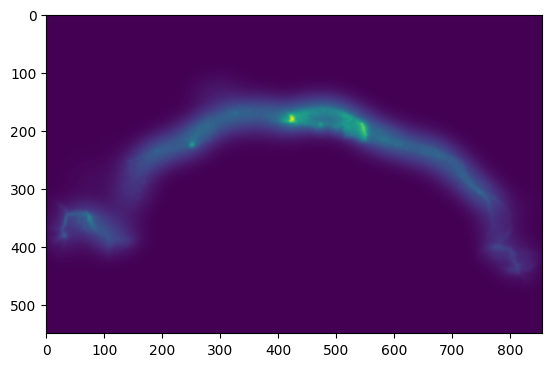

In [19]:
plt.imshow(epithelial_r[y])

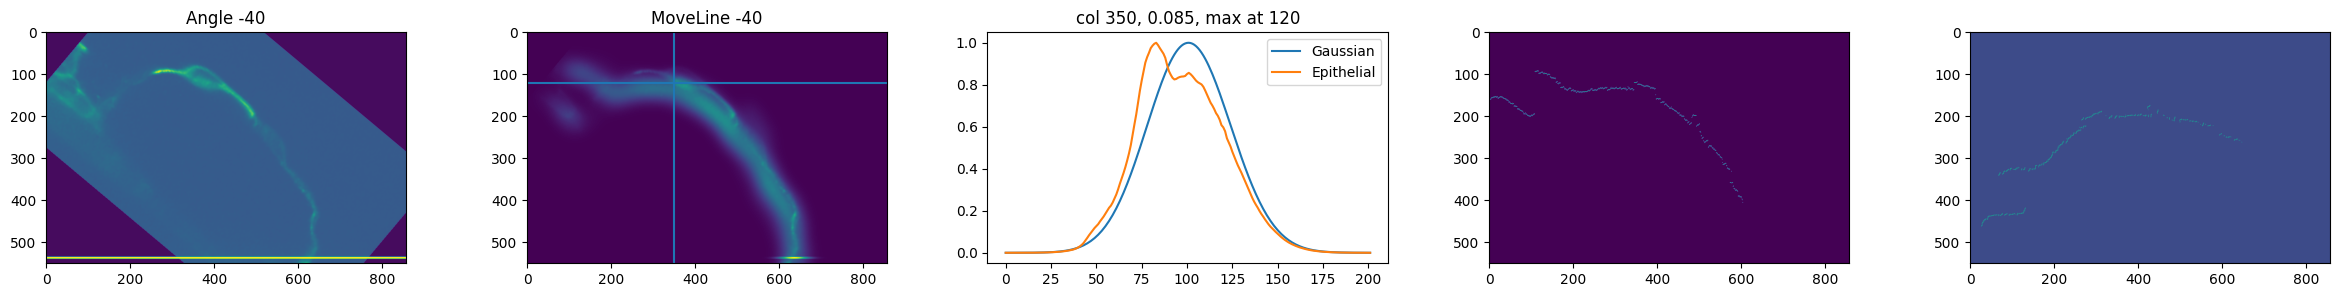

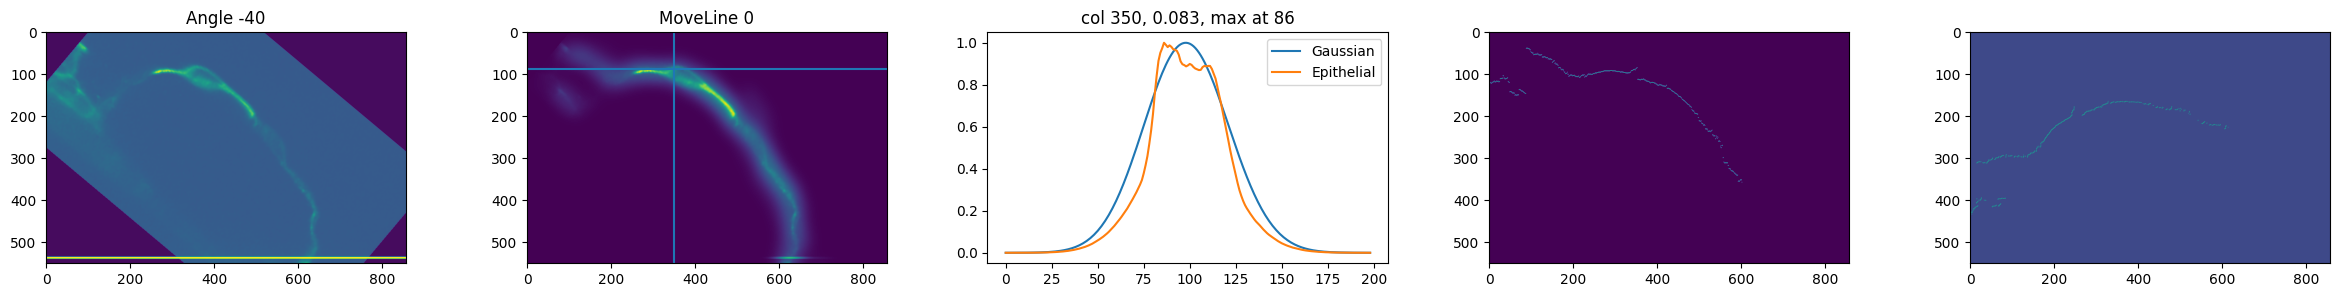

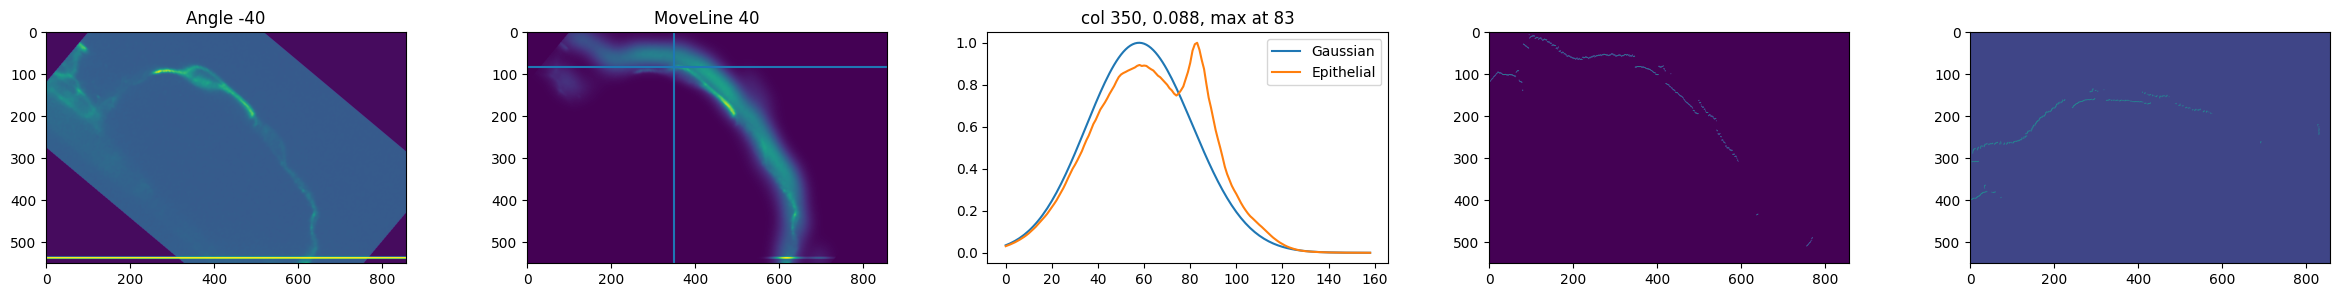

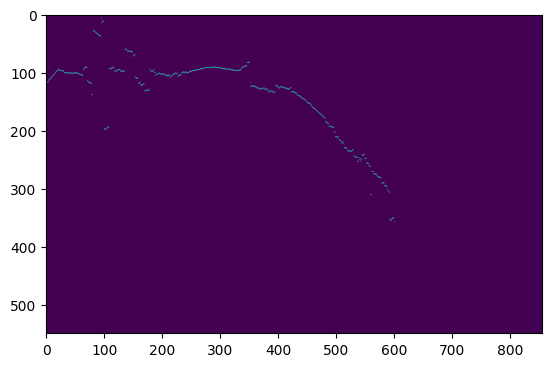

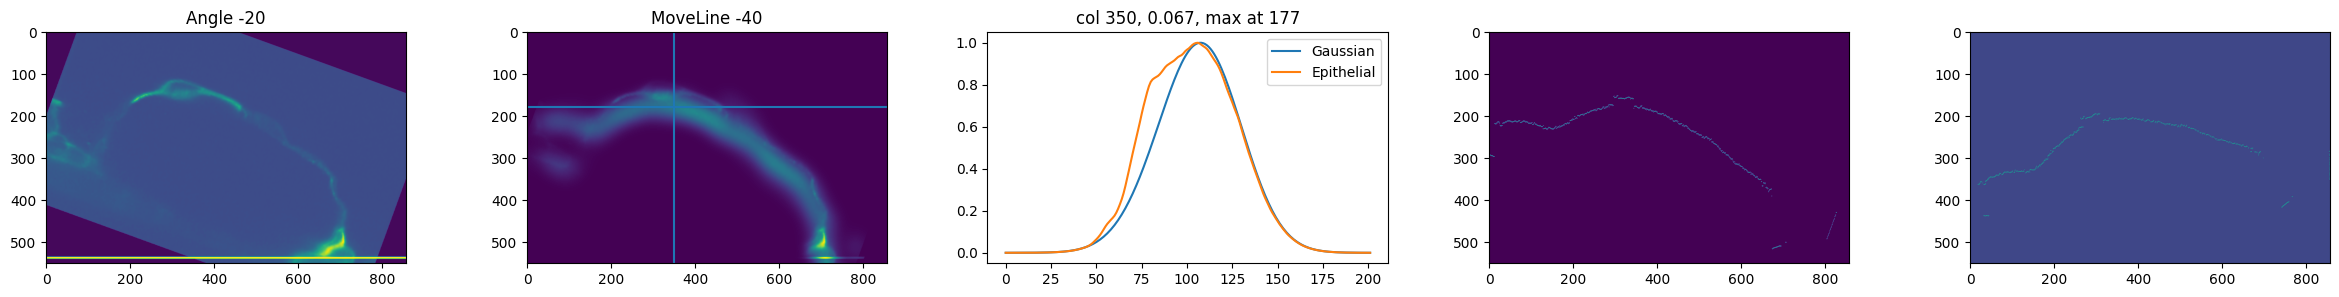

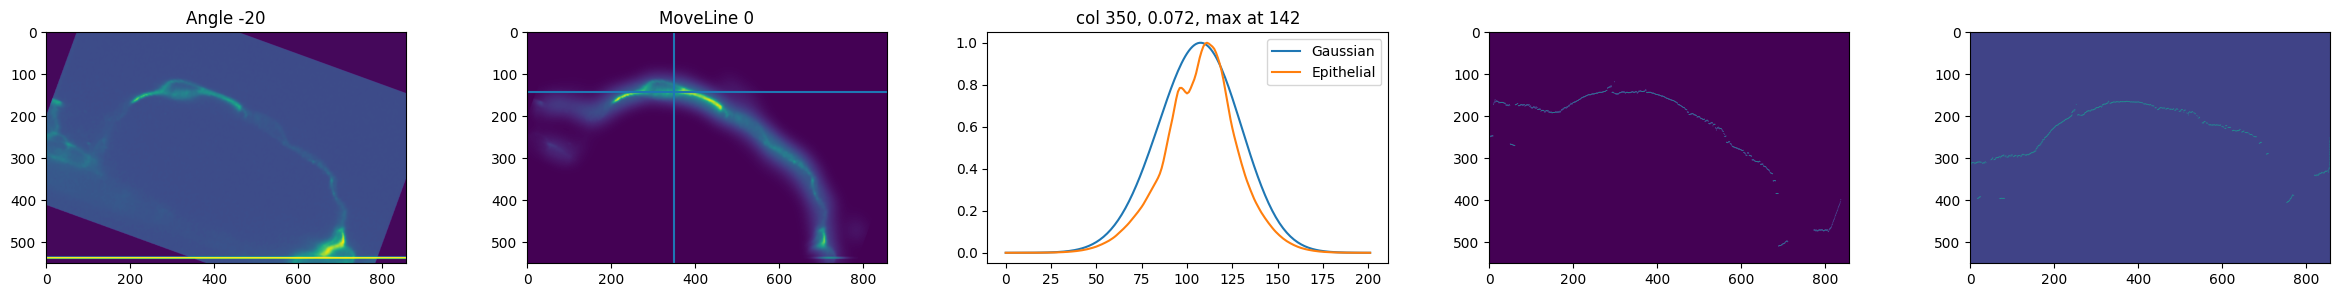

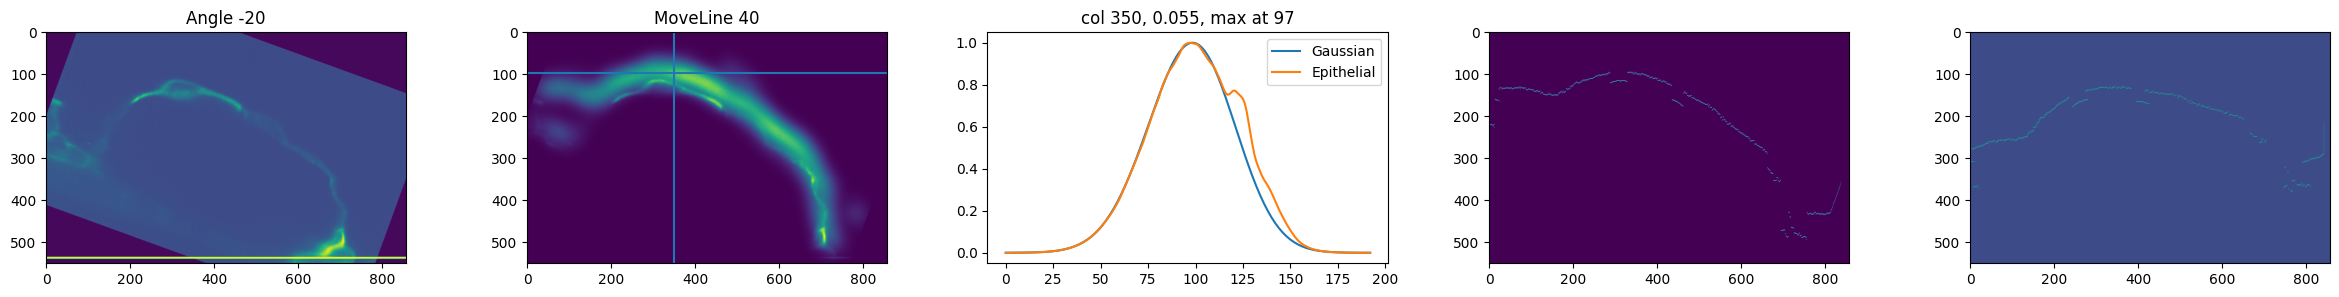

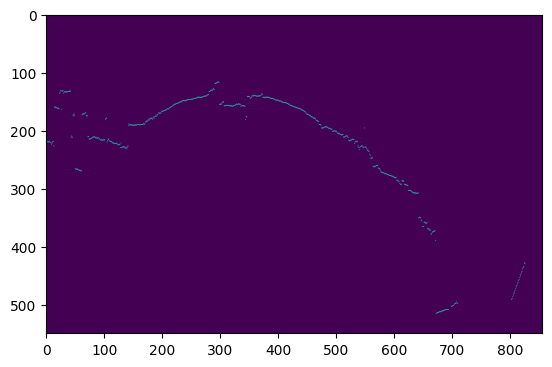

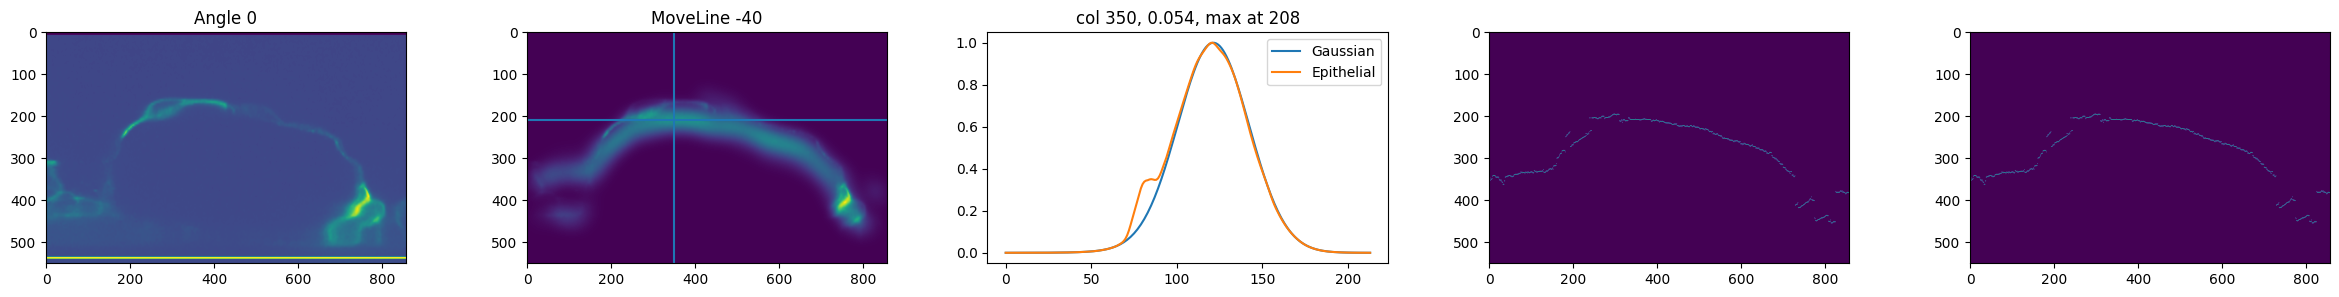

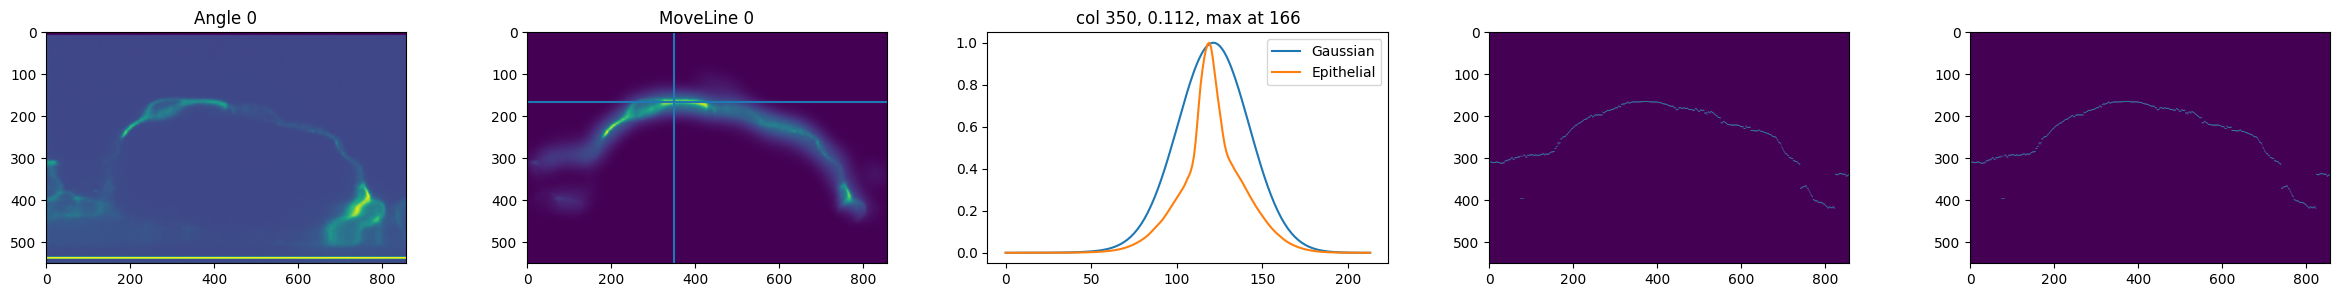

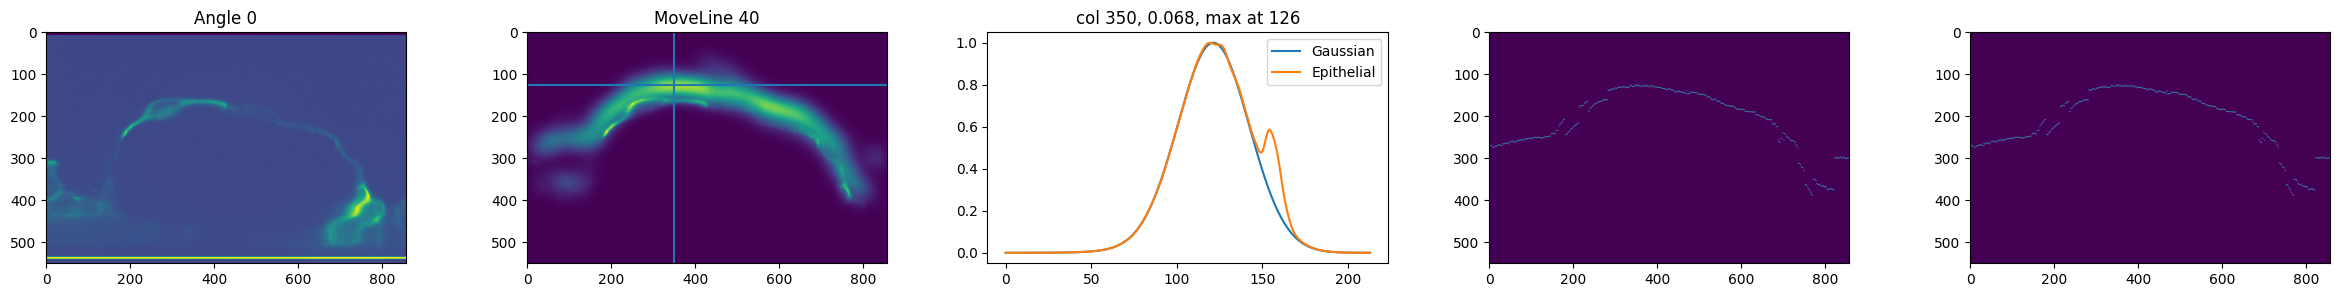

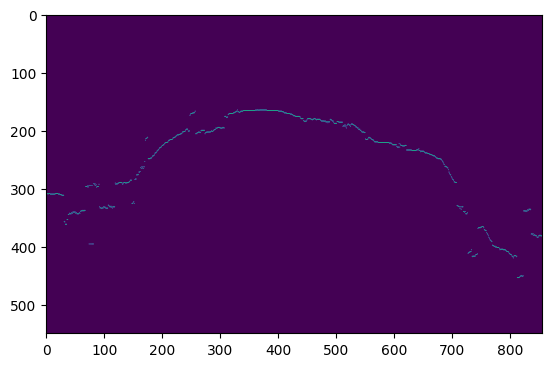

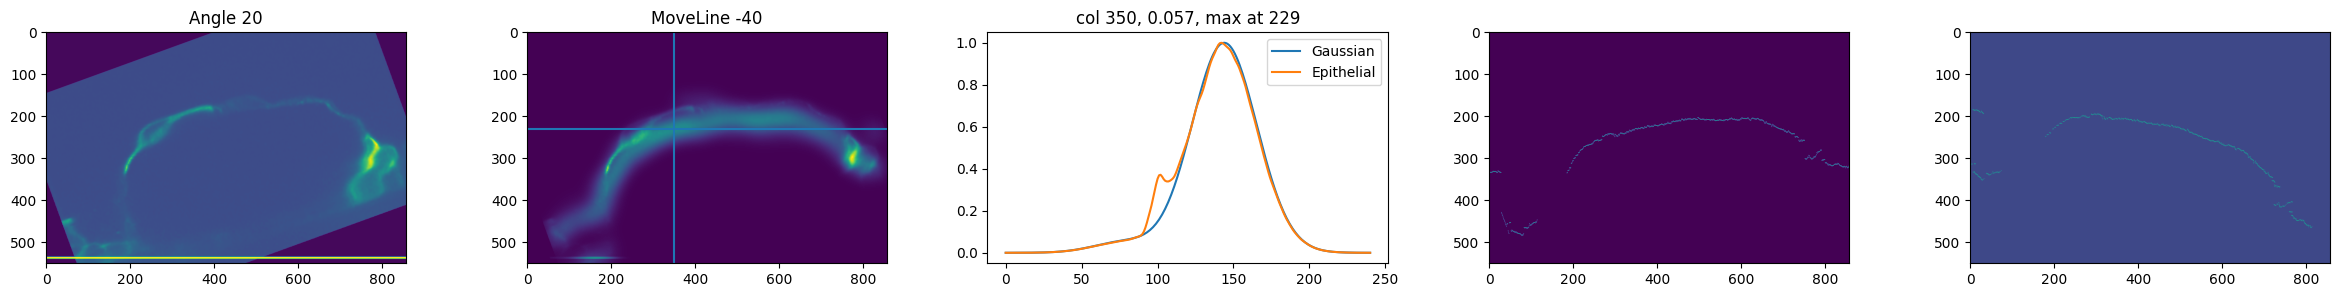

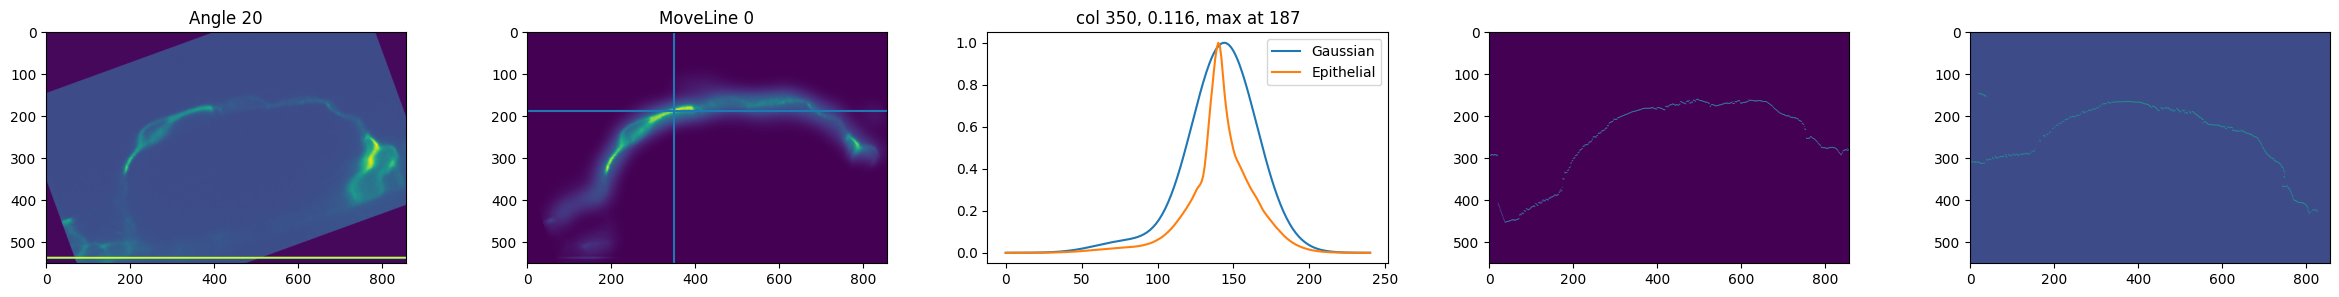

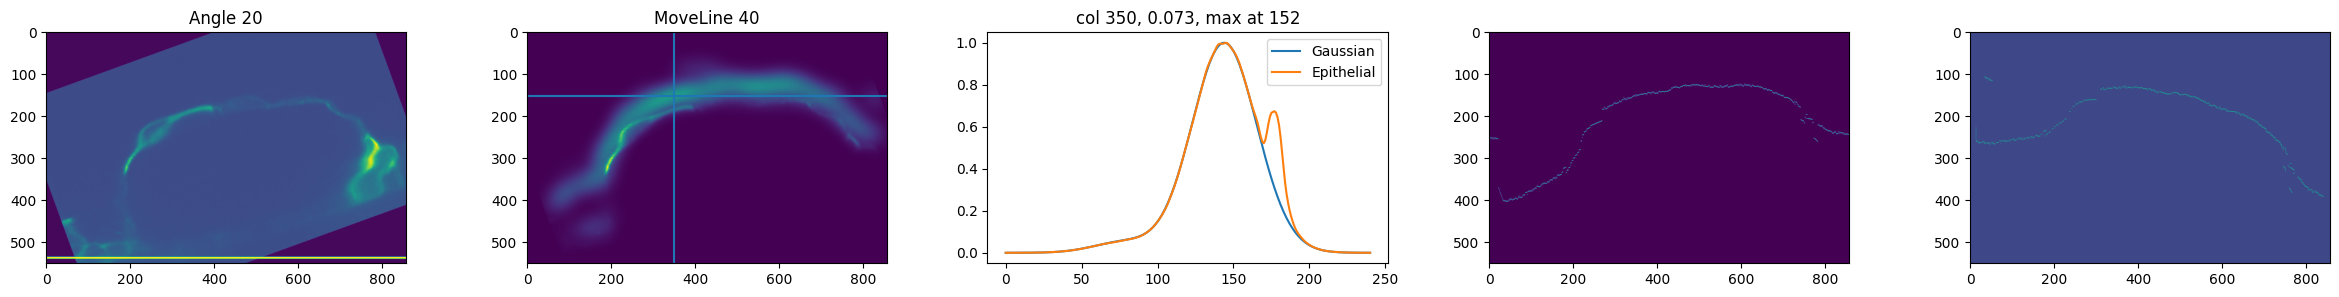

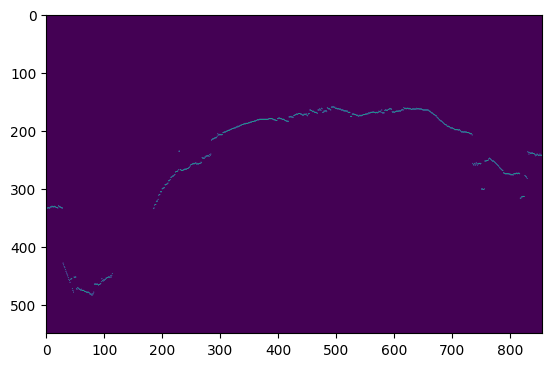

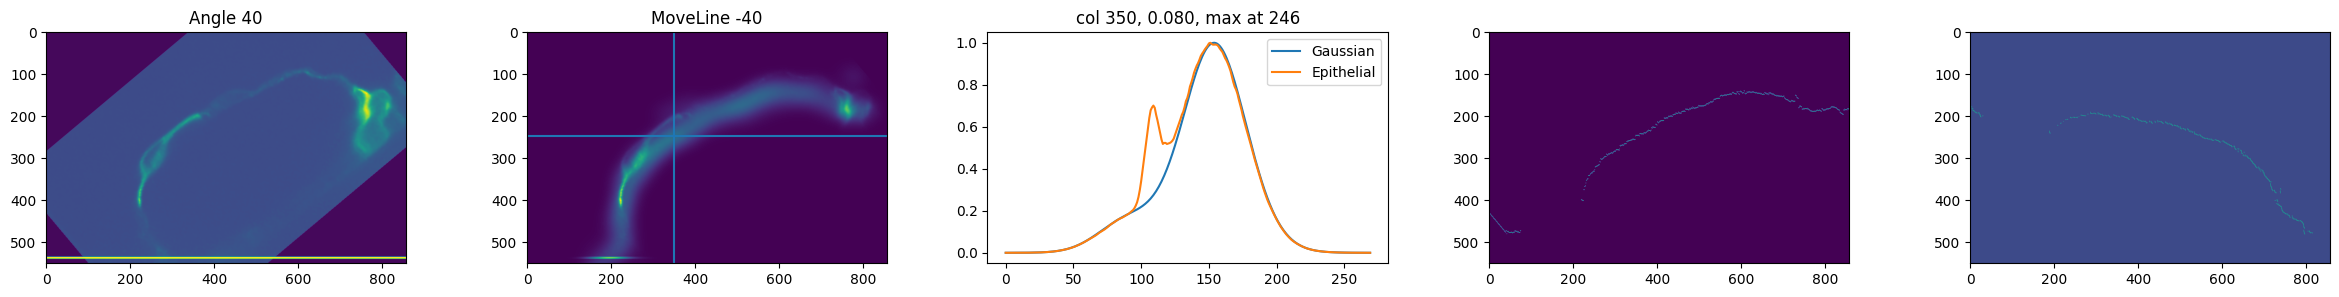

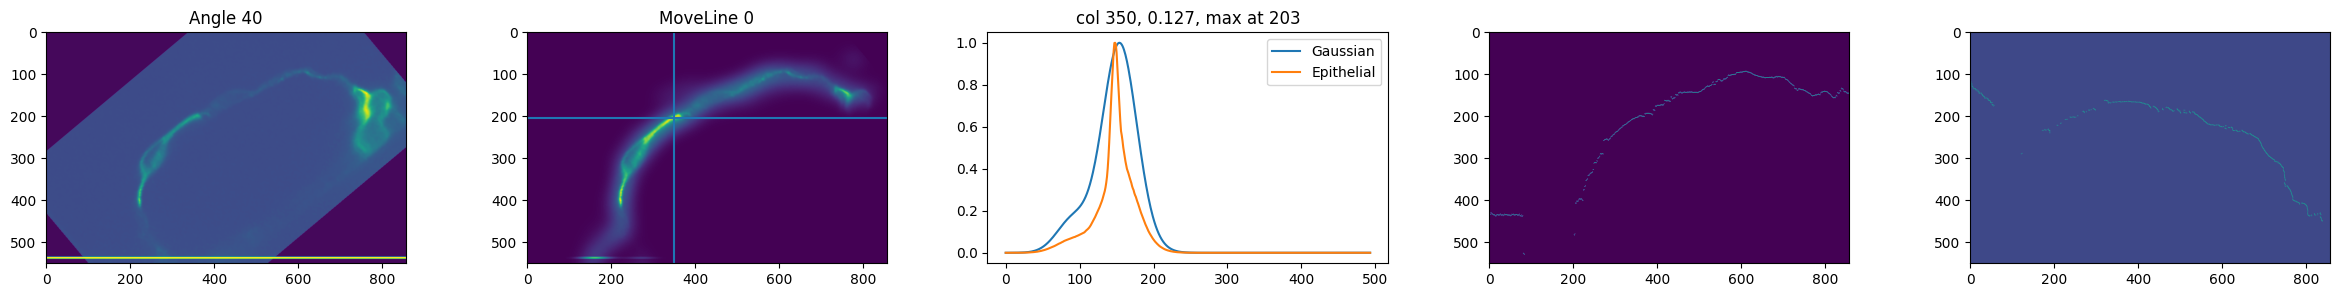

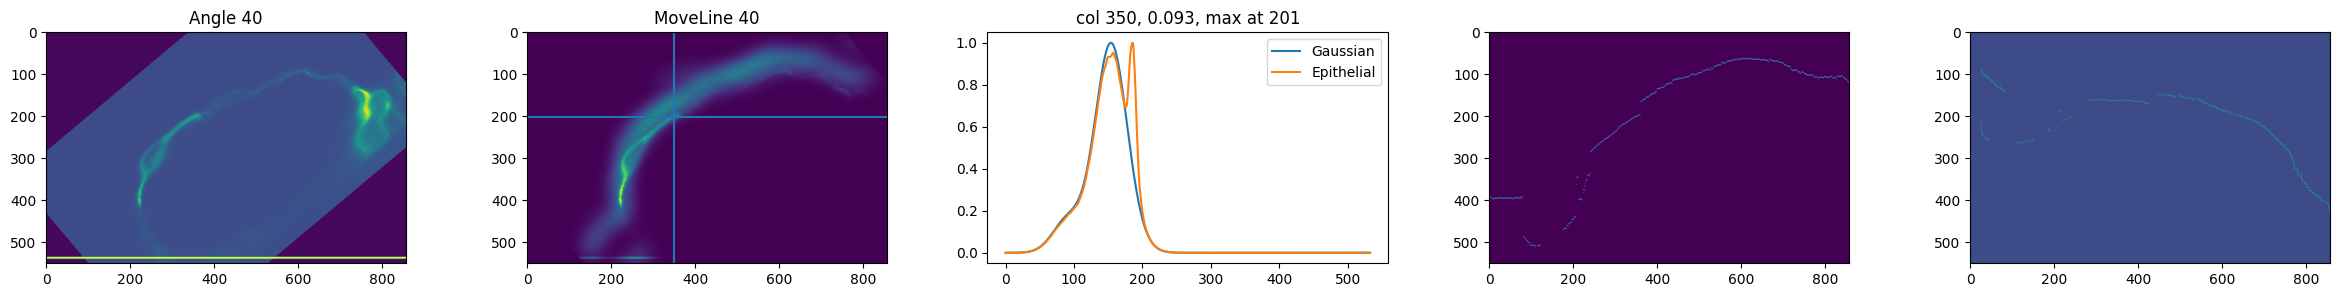

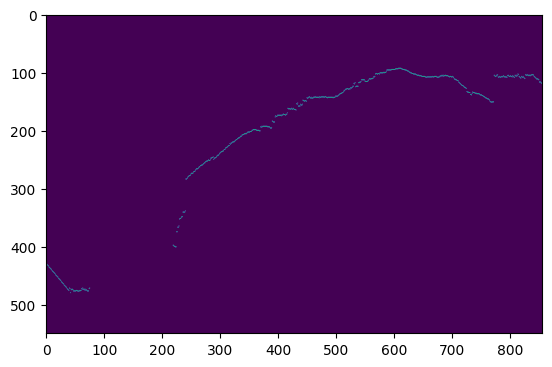

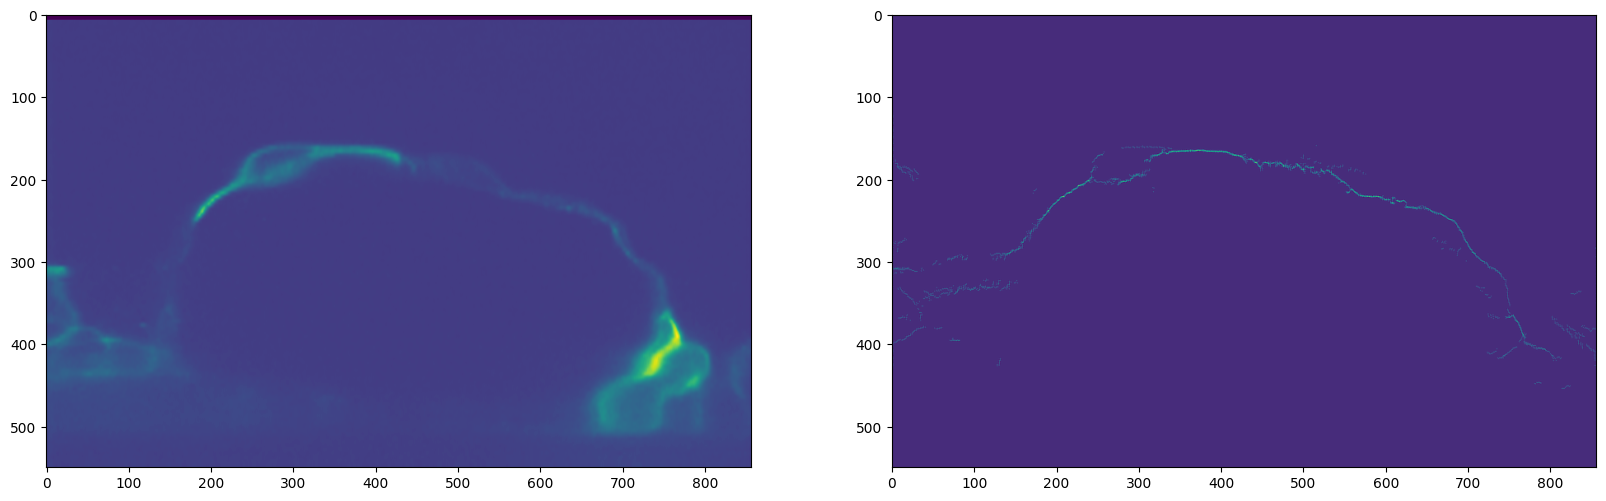

In [20]:
y = 410

angle = 40
angles = [i for i in range(-angle, angle+1, 20)]

moveLine = 40
moveLines = [i for i in range(-moveLine, moveLine+1, 40)]

# angles = [0]

total_apical = super_apical(image_r[y], gaussian_line_r[y], angles, moveLines, margin_cut=20, plots=True);

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(image_r[y])
plt.subplot(122)
plt.imshow(common_functions.normalize_image(total_apical))
plt.show()

In [21]:
if os.path.isfile(wd+'_apical_dots_total_sum_hull_mask_2.tif'):
    total_apical = sk.io.imread(wd+'_apical_dots_total_sum_hull_mask_2.tif')
else:
    angle = 40
    angles = [i for i in range(-angle, angle+1, 20)]

    moveLine = 40
    moveLines = [i for i in range(-moveLine, moveLine+1, 40)]

    total_apical_r = Parallel(n_jobs=-1)(delayed(super_apical)(image_r_i, gaussian_line_r_i, angles, moveLines, margin_cut=5, plots=False) for image_r_i, gaussian_line_r_i in zip(image_r, gaussian_line_r))
    total_apical_r = np.array(total_apical_r)
    total_apical_r[total_apical_r<0] = 0
    total_apical = np.transpose(total_apical_r, axes=(1,2,0))

    tiff.imwrite(wd+'_apical_dots_total_sum_hull_mask_2.tif', common_functions.normalize_image(total_apical, 255).astype(np.uint8))

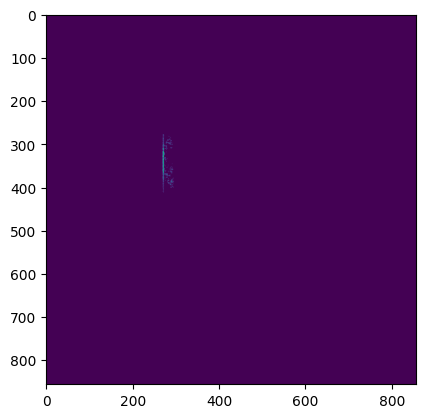

In [22]:
plt.imshow(total_apical[100])

In [23]:
total_apical = sk.io.imread(wd+'_apical_dots_total_sum_hull_mask_2.tif')

total_apical = cut_image(total_apical, z, z1, x, x1)

total_apical[:, :20, :] = 0
total_apical[:, -20:, :] = 0

total_apical_gaussian = common_functions.get_3D_gaussian(total_apical)


tiff.imwrite(wd+'_apical_dots_total_sum_hull_mask_gaussian_2.tif', common_functions.normalize_image(total_apical_gaussian, 255).astype(np.uint8))